In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import os
import math
import re

from nilearn import datasets, plotting
from nilearn import maskers, image
import matplotlib.pyplot as plt
import nibabel

Function to extract the path of files with specific name structure.

In [3]:
def get_file_path(main_directory,file_name):
    """
    Get the path of files for different subjects.
    
    Args:
    -----
      *main_directory* : string
        location of the main directory having all the subjects.
      *file_name* : string
        end of the file name which you are looking for including the file type
    Returns:
    --------
      *file_path* : dictionary
        dictionary with keys as subject_numbers and values as respective file path.
    """
    

    # Get a list of subject directories that start with "sub-"
    subject_directories = sorted([d for d in os.listdir(main_directory) if os.path.isdir(os.path.join(main_directory, d)) and d.startswith("sub-")])

    # Initialize lists to store data
    fmri_path = []
    file_path = {}

    # Loop through subject directories
    for subject_dir in subject_directories:
        fmri_path = []
        subject_path = os.path.join(main_directory, subject_dir)
        func_dir = os.path.join(subject_path, "func")

        if os.path.exists(func_dir) and os.path.isdir(func_dir):
            # Assuming fMRI files have a common pattern, such as '*.nii.gz' inside the "func" subdirectory
            fmri_files = [f for f in os.listdir(func_dir) if f.endswith(file_name)]

            # Loop through fMRI files
            for fmri_file in fmri_files:
                fmri_path.append(os.path.join(func_dir, fmri_file))
            file_path[subject_dir]= sorted(np.array(fmri_path))

    return(file_path)

Code to extract the run number from the file name

In [ ]:
def extract_task_run_from_filename(filename):
    pattern = r'task-(rest|sleep)_run-\d+'
    match = re.search(pattern, filename)
    return match.group() if match else None

Code to extract time series from specific ROIs based on the literature

In [ ]:
from nilearn.input_data import NiftiSpheresMasker
import pandas as pd
import numpy as np


def get_roi_time_series(fmri_path,atlas_dir,window_size_seconds=30,display_report=False):

    # Array of region names
    roi_names = [
        "Cuneus", "Middle occipital gyrus", "Middle occipital gyrus", 
        "Dorsal anterior cingulate", "Superior temporal gyrus", "Superior temporal gyrus",
        "Superior temporal gyrus", "Superior temporal gyrus", "Supplementary motor area", 
        "Postcentral gyrus", "Postcentral gyrus", "ORBmid", 
        "Precuneus", "Angulargyrus", "Angulargyrus", 
        "Middle frontal gyrus", "Middle frontal gyrus", "Precuneus", 
        "Supramarginal gyrus", "Supramarginal gyrus", "Thalamus", "Thalamus"
    ]

    # Array of roi coordinates
    roi_coords = [
        (2, -82, 20), (30, -90, 16), (-26, -90, 16),
        (2, 6, 44), (8, -2, -4), (-54, -2, -8),
        (62, -22, 16), (-58, -22, 8), (-2, -14, 48),
        (50, -14, 52), (-38, -14, 52), (2, 54, -8),
        (2, -62, 44), (50, -66, 28), (-46, -70, 28),
        (34, 46, 20), (-34, 42, 20), (10, -42, 48),
        (58, -38, 28), (-58, -42, 28), (8, -18, 8), (-8, -18, 8)
    ]

    n_regions = len(roi_names)

    # Adjust the radius as per your requirement
    masker = NiftiSpheresMasker(
        seeds=roi_coords,
        radius=8,
        detrend=True,
        standardize=True,
        low_pass=None,
        high_pass=None,
        t_r=None,
        memory='nilearn_cache',
        memory_level=1,
        verbose=0
    )

    time_series = masker.fit_transform(fmri_path)

    # Display report if needed
    if display_report:
        print("Dimension of the fMRI signal (x,y,z,timestamps): ", nibabel.load(fmri_path).shape)
        print("Dimension of the combined time series (timestamps, voxels): ", time_series.shape)
        print(f'Combined atlas has {n_regions} ROIs.')
        print(roi_names)

    window_size = int(window_size_seconds / 2.1)  # The normal window size
    first_window_correction = 5  # TRs to remove for the first epoch

    # Adjusted to account for the shortened first window
    adjusted_length = len(time_series[:, 0]) - first_window_correction
    num_windows = 2 + ((adjusted_length - window_size) // window_size)
    n_regions = time_series.shape[1]
    region_ts = np.empty((num_windows, n_regions), dtype=object)
    region_index = 0

    for region in zip(*time_series):
        # Special handling for the first window
        start_idx = 0
        end_idx = window_size - first_window_correction
        region_ts[0, region_index] = region[start_idx:end_idx]

        # Process subsequent windows
        for i in range(1, num_windows):
            start_idx = (i * window_size) - first_window_correction
            end_idx = start_idx + window_size
            region_ts[i, region_index] = region[start_idx:end_idx]

        region_index += 1

    # Construct DataFrame with appropriate column names
    columns = [f'{label}' for i, label in enumerate(roi_names, start=1)]
    region_ts_df = pd.DataFrame(region_ts, columns=columns)
    return region_ts_df


atlas_dir = "../python_scripts/resources/atlas"
fmri_files = get_file_path("../output_directory", "postproc_smooth.nii.gz")
# selected_keys = ['sub-02']
# # # Creating a new dictionary with only the selected keys
# fmri_files = {key: fmri_files[key] for key in selected_keys}

roi_ts_dfs = []
for subject, fmri_file in fmri_files.items():
        for file_path in fmri_file:
          region_ts_df = get_roi_time_series(file_path, atlas_dir,window_size_seconds=30,display_report=False)
          region_ts_df.insert(0, 'run', extract_task_run_from_filename(os.path.basename(file_path)))
          region_ts_df.insert(0, 'subject', subject)
          roi_ts_dfs.append(region_ts_df)
          print(f"{extract_task_run_from_filename(os.path.basename(file_path))} of {subject} successfully completed")

result_df = pd.concat(roi_ts_dfs, ignore_index=True)

result_df.to_csv('../output_directory/evaluation_dataset/roi_dataset/roi_dataset_corrected_filtered.csv', index=False, header=True)


Script to get the ROI Evaluation Dataset with all the following information:
    - Grouped Subject having same name, run and consecutive sleep stages
    - Total datapoints representing the number of epochs

In [ ]:
def read_csv(file_path):
    return pd.read_csv(file_path)

# Reading the uploaded CSV file
df = read_csv('../output_directory/evaluation_dataset/roi_dataset/roi_dataset.csv')

def process_data(df):
    # Renaming columns for clarity
    df.columns.values[0:3] = ['subject', 'run', 'sleep_stage']

    # Identify consecutive series and assign group IDs
    consecutive_series = (df['subject'] != df['subject'].shift(1)) | \
                         (df['run'] != df['run'].shift(1)) | \
                         (df['sleep_stage'] != df['sleep_stage'].shift(1))
    group_id = consecutive_series.cumsum()
    
    # Group by 'subject', 'run', 'sleep_stage', and group_id
    grouped = df.groupby([df.columns[0], df.columns[1], df.columns[2], group_id],sort=False)
    
    aggregation = {col: lambda x: list(x) for col in df.columns[3:]}
    processed_data = grouped.agg(aggregation).reset_index()

    processed_data.insert(4, 'Total datapoints', processed_data.iloc[:,4].apply(lambda x: len(x)))
    # processed_data['Total datapoints'] = processed_data.apply(lambda row: 9 + (len(row.iloc[4]) - 1) * 14, axis=1)
    processed_data = processed_data.drop('level_3', axis=1)
    return processed_data

processed_df = process_data(df)

def write_to_csv(df, file_path):
    df.to_csv(file_path, index=False)

output_file_path = '../output_directory/evaluation_dataset/roi_dataset/roi_eval_dataset.csv'
write_to_csv(processed_df, output_file_path)

In [ ]:
def read_csv(file_path):
    return pd.read_csv(file_path)

# Reading the uploaded CSV file
df = read_csv('../output_directory/evaluation_dataset/harvard_atlas_dataset/eval_dataset_corrected.csv')

def process_data(df):
    # Renaming columns for clarity
    df.columns.values[0:3] = ['subject', 'run', 'sleep_stage']
    
    # Group by 'subject', 'run', 'sleep_stage', and group_id
    grouped = df.groupby([df.columns[0], df.columns[2]])
    
    aggregation = {col: lambda x: list(x) for col in df.columns[3:]}
    processed_data = grouped.agg(aggregation).reset_index()

    return processed_data

processed_df = process_data(df)

def write_to_csv(df, file_path):
    df.to_csv(file_path, index=False)

output_file_path = '../output_directory/evaluation_dataset/harvard_atlas_dataset/ho_eval_dataset_all_grouped.csv'
write_to_csv(processed_df, output_file_path)

PSD Slope Implementation:
    - New metrics which calculates the slope of the PSD graph for each sleep score.

In [4]:
import numpy as np
from scipy.optimize import curve_fit
from scipy.signal import spectrogram
import matplotlib.pyplot as plt
from fooof import FOOOF


def get_spectral_features(time_series,normalize,plot=False):
    time_series = np.array(time_series)
    window_length = 104  # in seconds
    window_length_volumes = int(window_length / 2.1)
    low_freq_band=(0, 0.1)
    high_freq_band=(0.1, 0.25)

    frequencies, _, psd = spectrogram(time_series, fs=1 / 2.1, window='hamming', nperseg=window_length_volumes)
    
    psd = np.mean(psd,axis=1)
    fm = FOOOF()
    freq_range = [0,0.2]
    fm.fit(frequencies, psd,freq_range)
    if (plot):
        
        fm.report(frequencies, psd,freq_range)

        # plt.figure(figsize=(10, 5))
        # plt.semilogy(frequencies, psd)
        # plt.semilogy(frequencies, power_law)
        # plt.title('Power Spectral Density')
        # plt.xlabel('Frequency (Hz)')
        # plt.ylabel('Power/Frequency (dB/Hz)')
        # plt.show()


    # min_val = np.min(np.log(psd))
    # psd = np.log(psd)+ np.abs(min_val)
    # psd = psd / np.max(psd)

    # Calculate the Spectral Entropy
    def band_entropy(freqs, psd, band):
        psd_normalized = psd / np.sum(psd)
        band_mask = (freqs >= band[0]) & (freqs <= band[1])
        band_psd = psd_normalized[band_mask]
        band_psd += np.finfo(float).eps
        entropy = -np.sum(band_psd * np.log2(band_psd))

        peak_idx = np.argmax(psd[band_mask])
        peak_freq = frequencies[band_mask][peak_idx]
        peak_power = psd[band_mask][peak_idx]

        return entropy,peak_freq,peak_power
    
    low_freq_entropy,low_peak_freq,low_freq_power = band_entropy(frequencies, psd, low_freq_band)
    high_freq_entropy,high_peak_freq,high_freq_power = band_entropy(frequencies, psd, high_freq_band)

    psd_slope = np.abs((high_freq_power - low_freq_power)/(high_peak_freq - low_peak_freq))

    spectral_entropy_lvh = low_freq_entropy - high_freq_entropy

    if normalize:
        spectral_entropy_lvh /= np.log2(len(psd))

    return low_peak_freq, low_freq_power , high_peak_freq, high_freq_power,spectral_entropy_lvh,fm.aperiodic_params_[1]

In [ ]:
import pandas as pd
import re

def read_csv(file_path):
    return pd.read_csv(file_path)

# Convert string representation of list of tuples to a list of floats
def convert_string_to_list(data_string):
    data_string = data_string[1:-1]
    tuples = re.findall(r'\((.*?)\)', data_string)
    list_of_floats = [float(num) for t in tuples for num in t.split(', ')]
    # print(list_of_floats)
    return list_of_floats

# Reading the uploaded CSV file
df = read_csv('../output_directory/evaluation_dataset/harvard_atlas_dataset/ho_eval_dataset_all_grouped.csv')

peak_freq={}
region_columns = df.columns[3:]


for region in region_columns:
    # peak_freq[region] = df.apply(lambda row: get_spectral_features(convert_string_to_list(row[region]),False)[2], axis=1).values
    df[region] = df.apply(lambda row: get_spectral_features(convert_string_to_list(row[region]),False,False)[5], axis=1)
    print(f"{region} completed")

# state_list= df["run"].apply(lambda x: 'rest' if 'rest' in x else 'sleep')
# df.insert(2, 'state', state_list)
df['sleep_stage'] = df['sleep_stage'].apply(lambda x: "W" if (x.split()[0] == 'W') else x.split()[0])

# Save the updated DataFrame to a new CSV file
df.to_csv('../output_directory/evaluation_dataset/hurst_evaluation/ho_slope_1byf_all.csv', index=False)

Box plots

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


def get_box_plot(W_data,_1_data ,_2_data,datapoints,samples_w,samples_1,samples_2):

    # Combine NREM1 and NREM2 data for one of the boxplots
    sleep_data = _1_data + _2_data

    plt.figure(figsize=(20, 15))

    # Plot boxplots for Wake vs Sleep
    plt.subplot(2, 1, 1)
    boxplot = plt.boxplot([W_data, sleep_data], labels=['Wake', 'Sleep'], 
                        showmeans=True, showfliers=False, meanline=True, sym='.')

    # Customize mean lines
    for mean in boxplot['means']:
        mean.set_color('green')
        mean.set_linewidth(2)
        mean.set_linestyle('--')
        x, y = mean.get_xdata(), mean.get_ydata()
        mean_value = y[0]
        plt.text(x[0], mean_value, f'mean: {mean_value:.2f}', 
                va='bottom', ha='left', color='green')  # Annotate mean value

    plt.xlabel('Subject State')
    plt.ylabel('Average Brain Hurst Exponent')
    plt.title(f'Box Plot of Average Hurst exponent by Wake vs Sleep for {(datapoints)*0.5} mins')
    plt.legend([f'Wake: {samples_w} samples , Sleep: {samples_1+samples_2} samples'])

    # Plot boxplots for Wake vs NREM1 vs NREM2
    plt.subplot(2, 1, 2)
    boxplot = plt.boxplot([W_data, _1_data, _2_data], labels=['Wake', 'NREM1', 'NREM2'], 
                        showmeans=True, showfliers=False, meanline=True, sym='.')

    # Customize mean lines
    for mean in boxplot['means']:
        mean.set_color('green')
        mean.set_linewidth(2)
        mean.set_linestyle('--')
        x, y = mean.get_xdata(), mean.get_ydata()
        mean_value = y[0]
        plt.text(x[0], mean_value, f'mean: {mean_value:.2f}', 
                va='bottom', ha='left', color='green')  # Annotate mean value

    plt.xlabel('Sleep Score')
    plt.ylabel('Average Hurst Exponent')
    plt.title(f'Box Plot of Average Hurst exponent by Wake vs NREM1 vs NREM2 for {(datapoints)*0.5} mins')
    plt.legend([f'Wake: {samples_w} samples , NREM1: {samples_1} samples, NREM2: {samples_2} samples'])

    plt.tight_layout()
    plt.show()

# Load the data
file_path = '../output_directory/evaluation_dataset/spectral_evaluation/spectral_dataset_roi_slope_all.csv'
df = pd.read_csv(file_path)

# Get all unique values of 'Total datapoints' column
total_datapoints_values = df['Total datapoints'].unique()

columns_to_consider = [df.columns[2]] + [df.columns[3]] + list(df.columns[4:])

# Group the DataFrame by 'sleep_stage' and 'Total datapoints'
grouped_data_w = df[df['sleep_stage'] == 'W'].groupby(['Total datapoints'])
grouped_data_1 = df[df['sleep_stage'] == '1'].groupby(['Total datapoints'])
grouped_data_2 = df[df['sleep_stage'] == '2'].groupby(['Total datapoints'])

run_freq_w = grouped_data_w['Total datapoints'].value_counts().to_dict()
run_freq_1 = grouped_data_1['Total datapoints'].value_counts().to_dict()
run_freq_2 = grouped_data_2['Total datapoints'].value_counts().to_dict()

grouped_data_w = df[df['sleep_stage'] == 'W'][columns_to_consider].groupby(['sleep_stage', 'Total datapoints']).mean()
grouped_data_1 = df[df['sleep_stage'] == '1'][columns_to_consider].groupby(['sleep_stage', 'Total datapoints']).mean()
grouped_data_2 = df[df['sleep_stage'] == '2'][columns_to_consider].groupby(['sleep_stage', 'Total datapoints']).mean()


# Filter the DataFrame for sleep stage 'W'
W_data = grouped_data_w.reset_index()
W_total_datapoints = W_data['Total datapoints'].unique()

# Filter the DataFrame for sleep stage '1'
_1_data = grouped_data_1.reset_index()
_1_total_datapoints = _1_data['Total datapoints'].unique()

# Filter the DataFrame for sleep stage '2'
_2_data = grouped_data_2.reset_index()
_2_total_datapoints = _2_data['Total datapoints'].unique()

# Compare the 'Total datapoints' values
common_total_datapoints = set(W_total_datapoints) & set(_1_total_datapoints) & set(_2_total_datapoints)

all_figures = []
# grouped_data_w.index
for i in np.sort(list(common_total_datapoints)):
    # Extract data based on sleep stage
    W_data = grouped_data_w.loc[("W",i)].tolist()
    _1_data = grouped_data_1.loc[("1",i)].tolist()
    _2_data = grouped_data_2.loc[("2",i)].tolist()
    
    get_box_plot(W_data,_1_data ,_2_data,i,run_freq_w[i],run_freq_1[i],run_freq_2[i])
    # all_figures.append(fig)

    

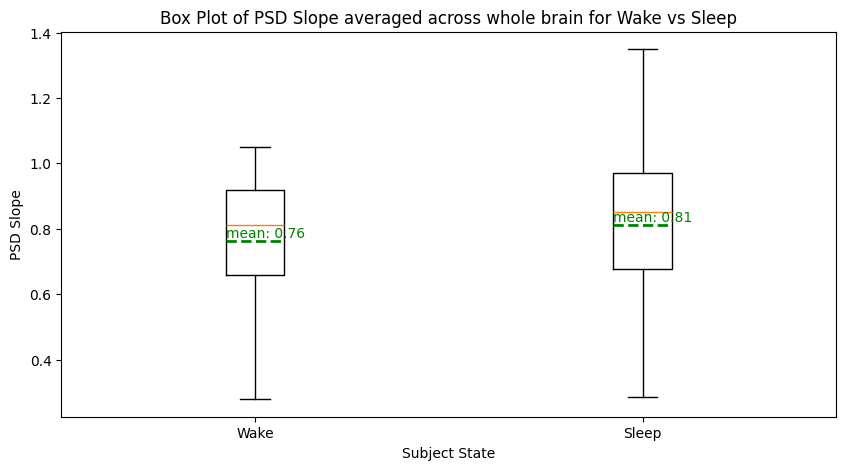

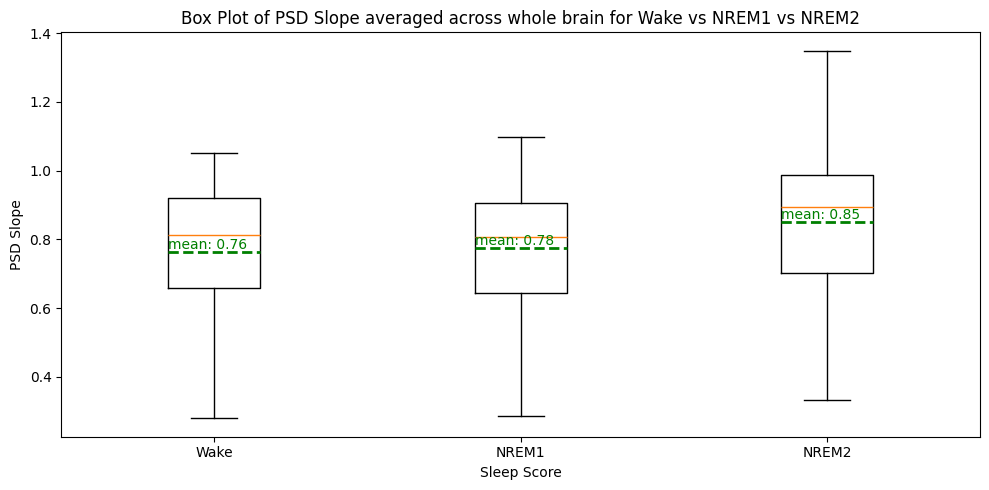

In [22]:
import pandas as pd
import matplotlib.pyplot as plt


def get_box_plot(W_data,_1_data ,_2_data):

    # Combine NREM1 and NREM2 data for one of the boxplots
    sleep_data = np.concatenate((_1_data, _2_data))
    
    plt.figure(figsize=(10, 5))

    # Plot boxplots for Wake vs Sleep
    boxplot = plt.boxplot([W_data, sleep_data], labels=['Wake', 'Sleep'], 
                        showmeans=True, showfliers=False, meanline=True, sym='.')

    # Customize mean lines
    for mean in boxplot['means']:
        mean.set_color('green')
        mean.set_linewidth(2)
        mean.set_linestyle('--')
        x, y = mean.get_xdata(), mean.get_ydata()
        mean_value = y[0]
        plt.text(x[0], mean_value, f'mean: {mean_value:.2f}', 
                va='bottom', ha='left', color='green')  # Annotate mean value

    plt.xlabel('Subject State')
    plt.ylabel('PSD Slope')
    plt.title('Box Plot of PSD Slope averaged across whole brain for Wake vs Sleep')

    # Plot boxplots for Wake vs NREM1 vs NREM2
    plt.figure(figsize=(10, 5))
    boxplot = plt.boxplot([W_data, _1_data, _2_data], labels=['Wake', 'NREM1', 'NREM2'], 
                        showmeans=True, showfliers=False, meanline=True, sym='.')

    # Customize mean lines
    for mean in boxplot['means']:
        mean.set_color('green')
        mean.set_linewidth(2)
        mean.set_linestyle('--')
        x, y = mean.get_xdata(), mean.get_ydata()
        mean_value = y[0]
        plt.text(x[0], mean_value, f'mean: {mean_value:.2f}', 
                va='bottom', ha='left', color='green')  # Annotate mean value

    plt.xlabel('Sleep Score')
    plt.ylabel('PSD Slope')
    plt.title('Box Plot of PSD Slope averaged across whole brain for Wake vs NREM1 vs NREM2')

    plt.tight_layout()
    plt.show()

# Load the data
file_path = '../output_directory/evaluation_dataset/hurst_evaluation/ho_slope_1byf_all.csv'
df = pd.read_csv(file_path)

# Get all unique values of 'Total datapoints' column
total_datapoints_values = df['Total datapoints'].unique()

columns_to_consider = [df.columns[1]] + list(df.columns[4:])

# Group the DataFrame by 'sleep_stage' and 'Total datapoints'
# grouped_data_w = df[df['sleep_stage'] == 'W']["Left Thalamus"]
# grouped_data_1 = df[df['sleep_stage'] == '1']["Left Thalamus"]
# grouped_data_2 = df[df['sleep_stage'] == '2']["Left Thalamus"]



grouped_data_w = df[df['sleep_stage'] == 'W'][columns_to_consider].groupby(['sleep_stage']).mean()
grouped_data_1 = df[df['sleep_stage'] == '1'][columns_to_consider].groupby(['sleep_stage']).mean()
grouped_data_2 = df[df['sleep_stage'] == '2'][columns_to_consider].groupby(['sleep_stage']).mean()

all_figures = []
# grouped_data_w.index


W_data = grouped_data_w.values[0]
_1_data = grouped_data_1.values[0]
_2_data = grouped_data_2.values[0]

get_box_plot(W_data,_1_data ,_2_data)
    # all_figures.append(fig)


Statistical Testing:
    - t-testing for Wake vs Sleep
    - Anova test for Wake vs N1 vs N2

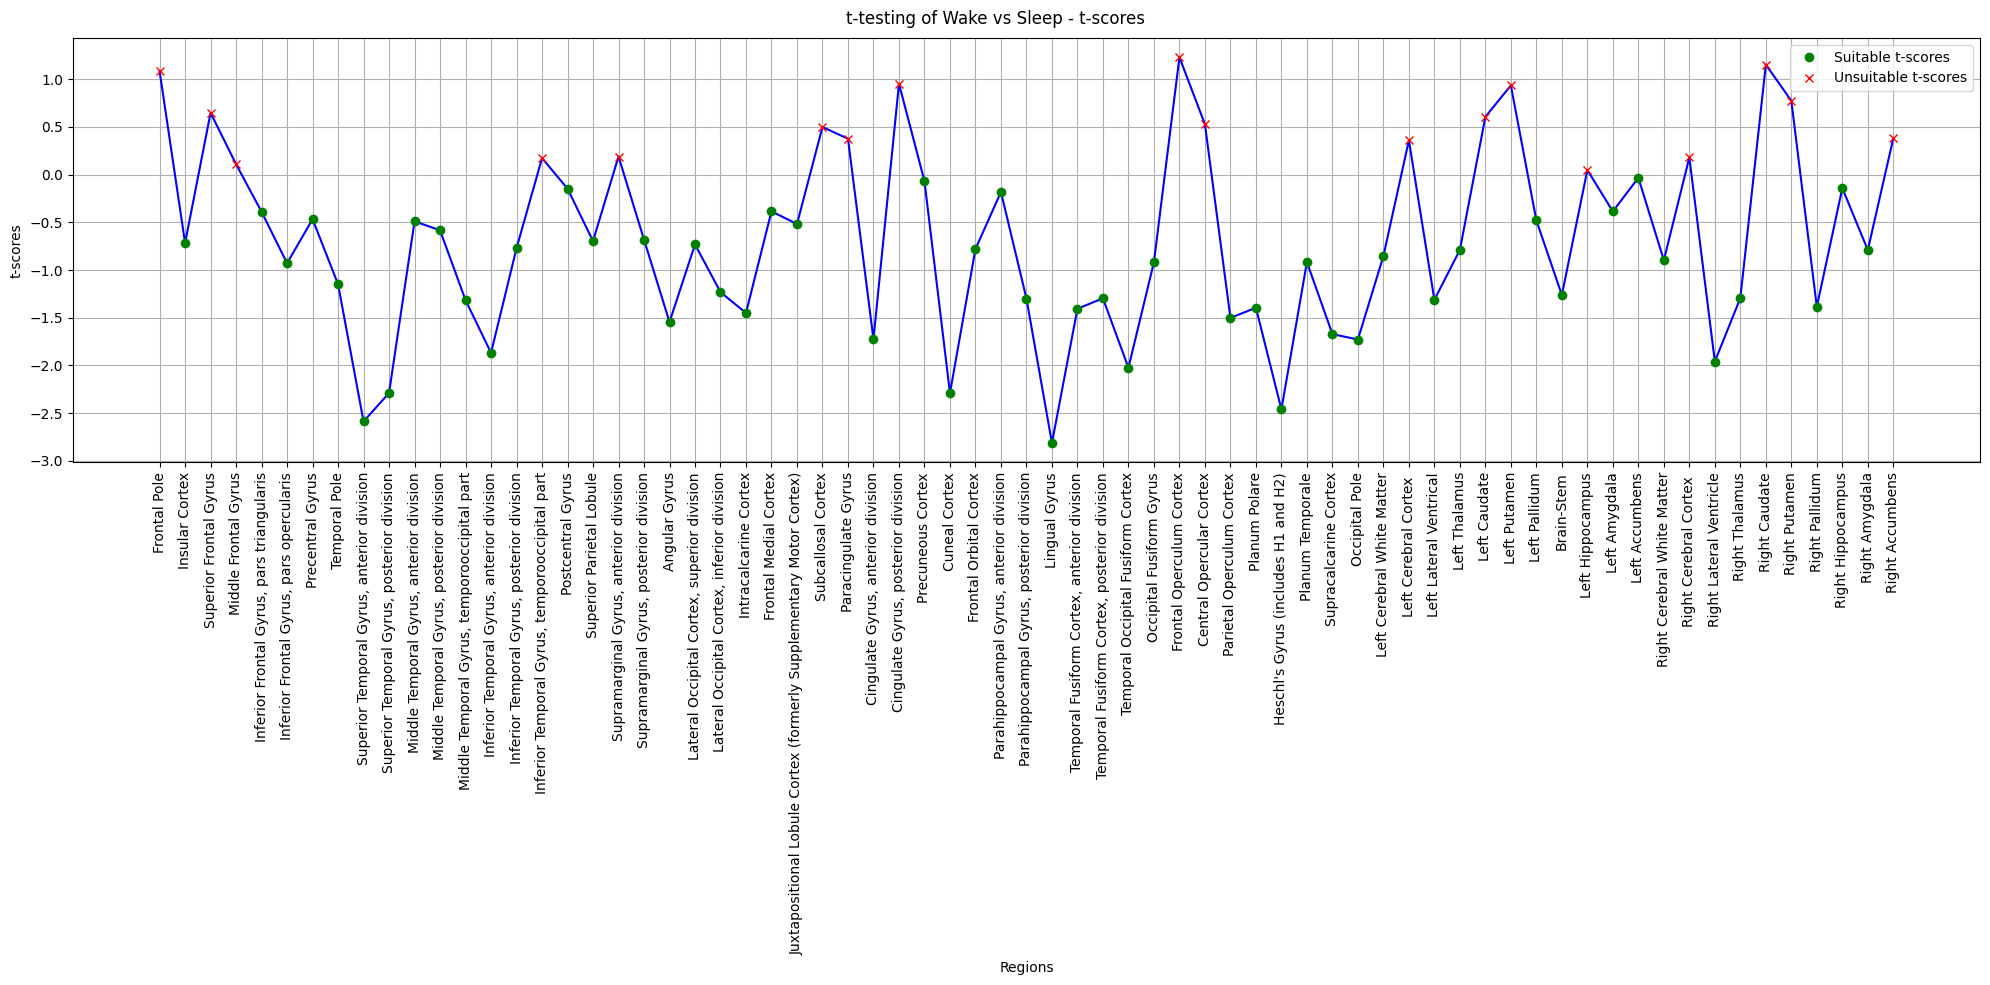

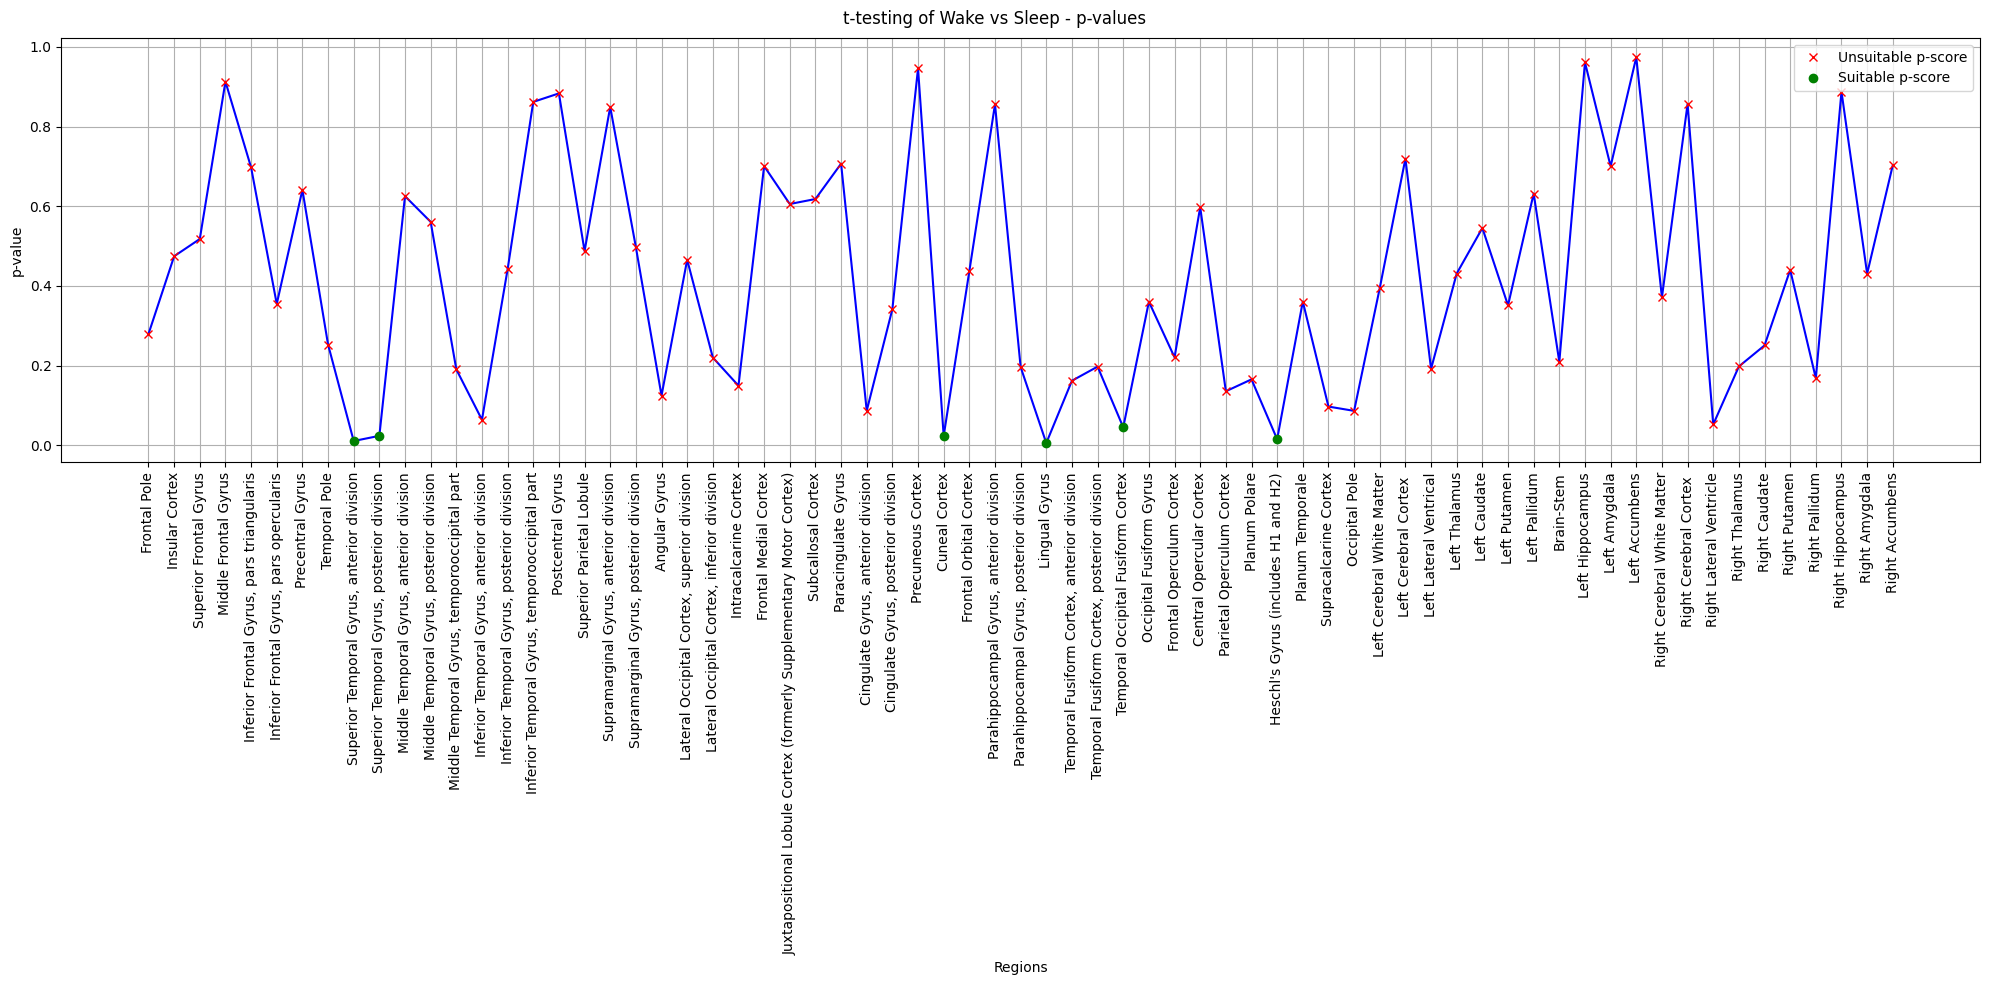

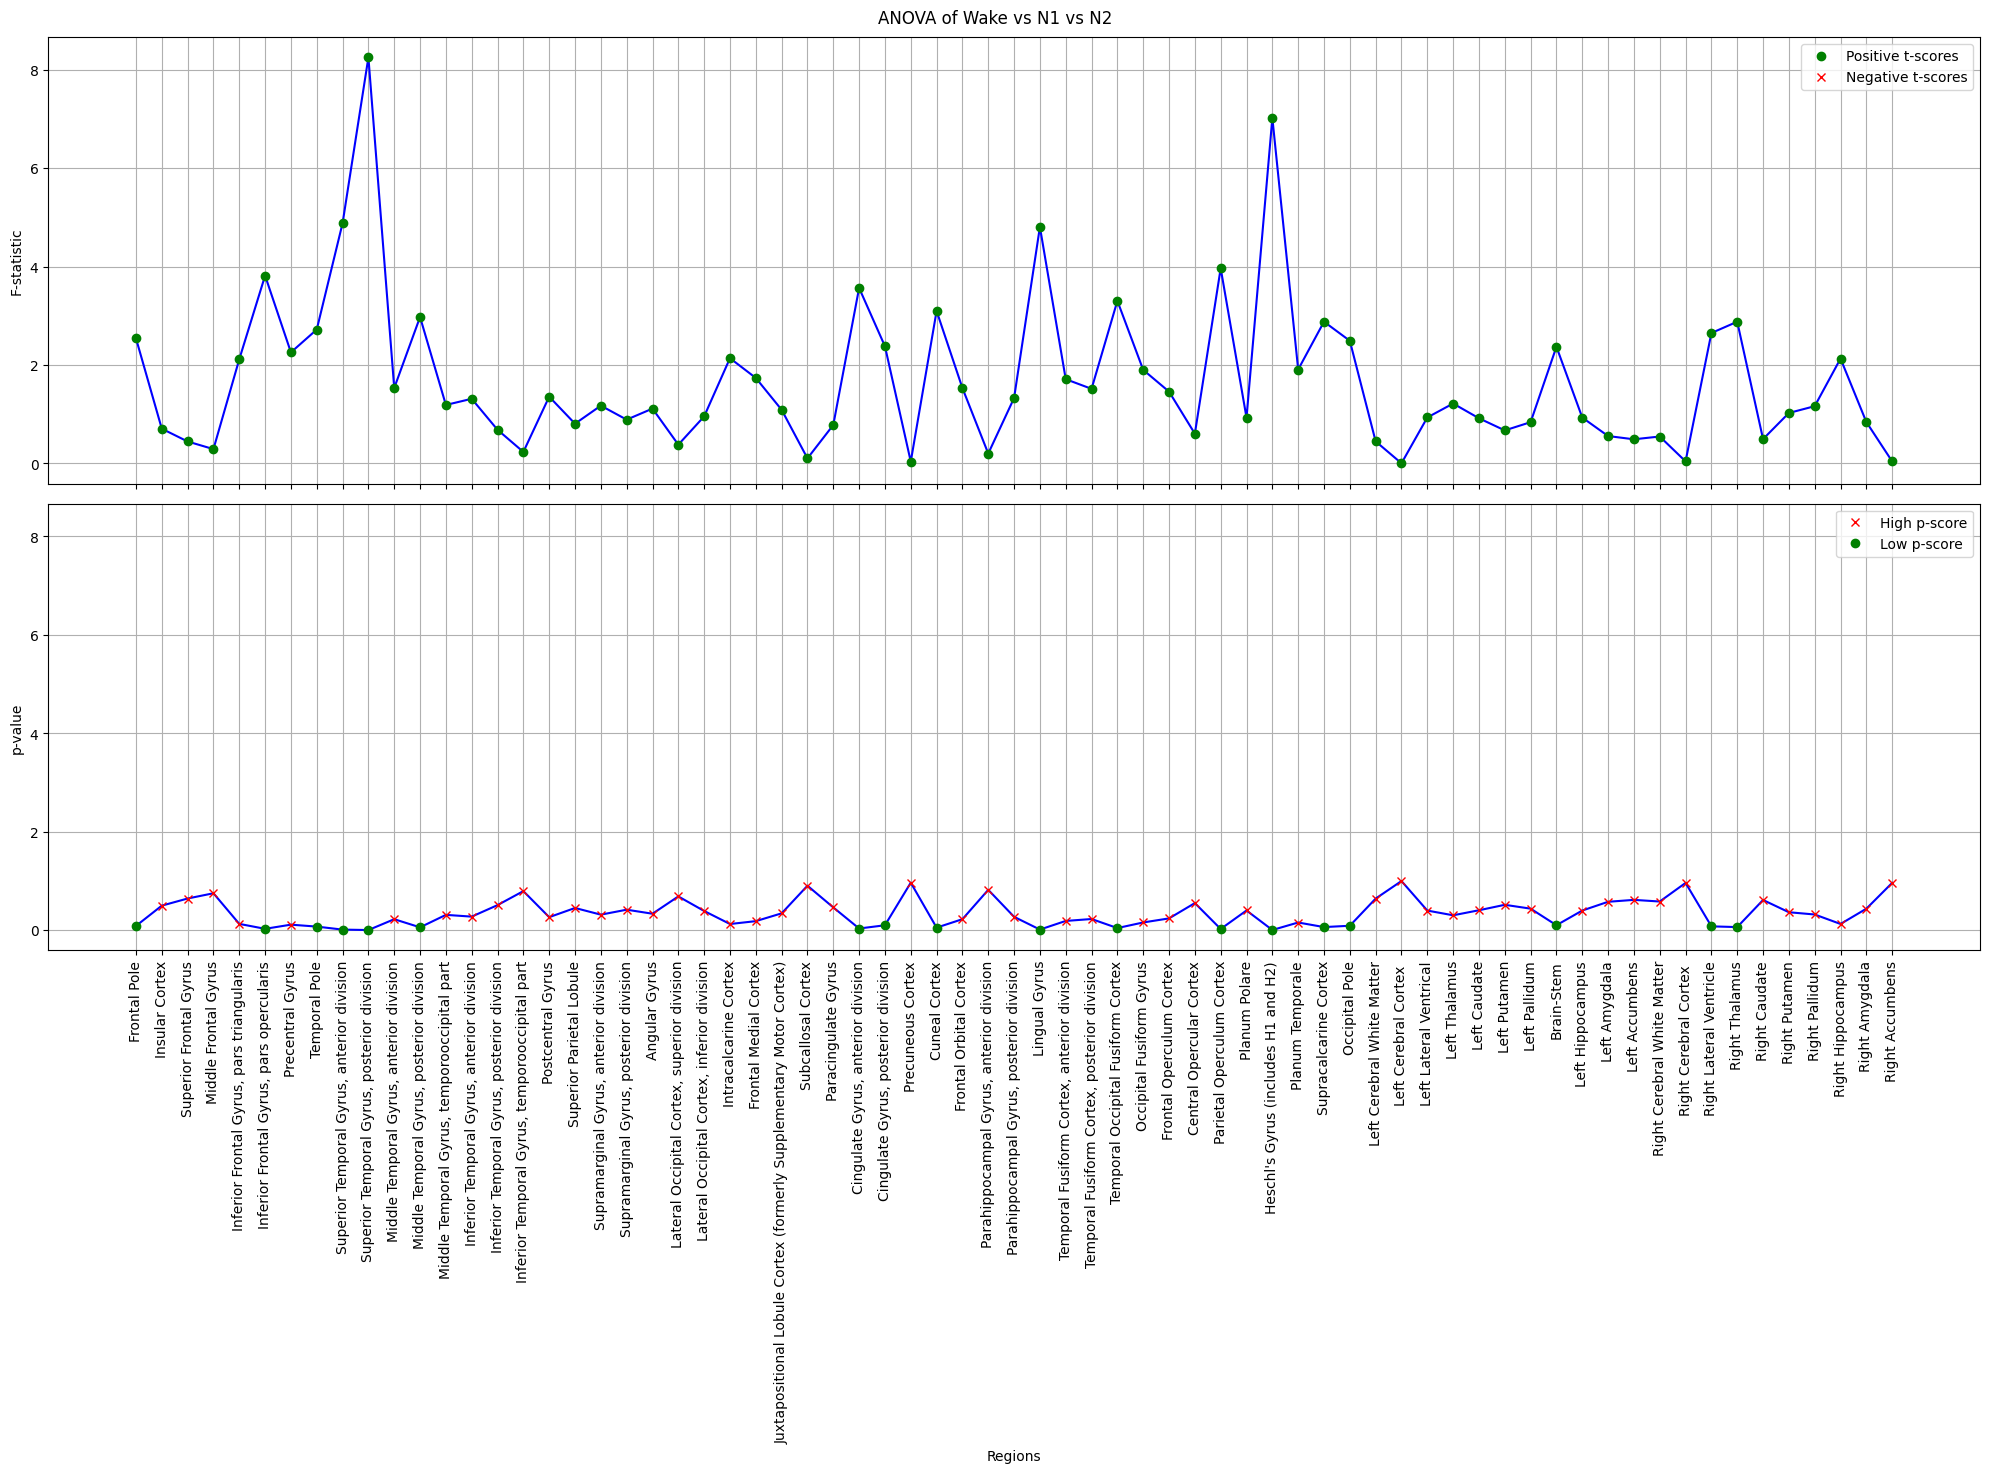

In [1]:
from t_test import evaluate_t_test
from anova_test import evaluate_anova_test

evaluate_t_test('../output_directory/evaluation_dataset/hurst_evaluation/ho_slope_1byf_all.csv', fdr_corrected = False, save_results = False)
evaluate_anova_test('../output_directory/evaluation_dataset/hurst_evaluation/ho_slope_1byf_all.csv', fdr_corrected = False, save_results = False)

Connectivity Matrix
- PSD slope
- Spectral Entropy

In [ ]:
import seaborn as sns

def calculate_mean(file_path, parameter_index):
    
    df = pd.read_csv(file_path)

    columns_to_consider = [df.columns[parameter_index]] + list(df.columns[5:])

    # Filter out zero values
    non_zero_df = df[df[columns_to_consider] != 0]

    # Group by parameter and calculate the mean for each region
    mean_non_zero_hurst_exponents = non_zero_df.groupby(df.columns[parameter_index], as_index=False).mean()

    return mean_non_zero_hurst_exponents


def compute_connectivity(hurst_exponents):
    num_regions = len(hurst_exponents)
    connectivity_matrix = np.zeros((num_regions, num_regions))
    for i in range(num_regions):
        for j in range(i + 1, num_regions):  # Only compute upper triangle (excluding diagonal)
            connectivity_matrix[i, j] = abs(hurst_exponents[i] - hurst_exponents[j])
            connectivity_matrix[j, i] = connectivity_matrix[i, j]  # Symmetric matrix
    return connectivity_matrix



In [ ]:
file_path = '../output_directory/evaluation_dataset/dfa_hurst_dataset.csv'
mean_hurst_per_sleep_stage = calculate_mean(file_path, 3)
sleep_stage_dict_cortical = {}
sleep_stage_dict_subcortical = {}

sleep_scores = ['W','1', '2']

for score in sleep_scores:
    # Filter the DataFrame for the current sleep score
    score_df = mean_hurst_per_sleep_stage[mean_hurst_per_sleep_stage['sleep_stage'] == score]

    # Extract connectivity data for the current sleep score
    connectivity_data = score_df.iloc[:, 5:].values  # Assuming connectivity data starts from column index 5
    hurst_connectivity = compute_connectivity(connectivity_data[0])
    # Plot the connectivity matrix
    plt.figure(figsize=(14, 10))
    sns.heatmap(hurst_connectivity, cmap='coolwarm', xticklabels=score_df.columns[5:], yticklabels=score_df.columns[5:])
    plt.title(f'Connectivity Matrix for hurst exponent Sleep Score {score}')
    plt.xlabel('Brain Regions')
    plt.ylabel('Brain Regions')
    plt.xticks(rotation=90)
    plt.show()

Test Script


FOOOF WARNING: Skipping frequency == 0, as this causes a problem with fitting.

FOOOF WARNING: Skipping frequency == 0, as this causes a problem with fitting.
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 0 - 1 Hz                         
                                 Frequency Resolution is 0.01 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -0.4365, 0.8820                                          
                                                

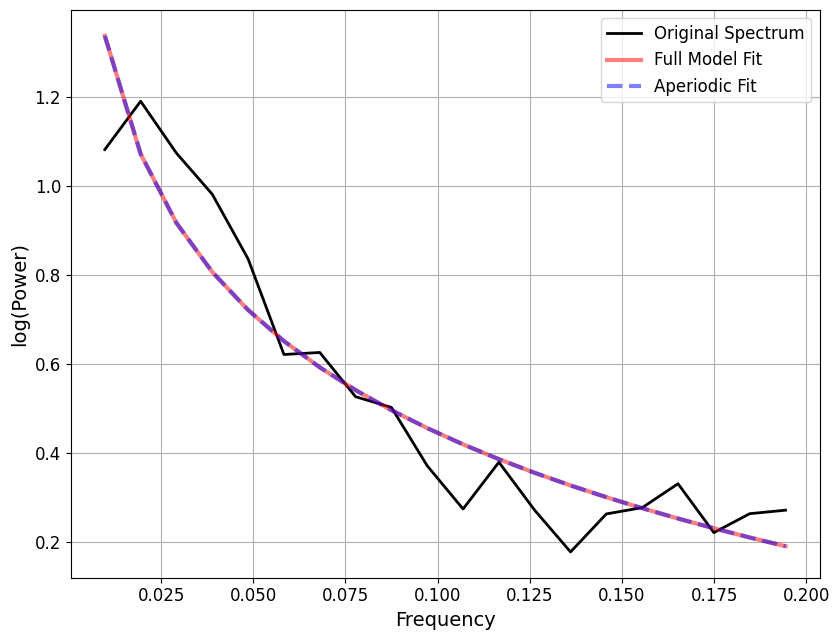

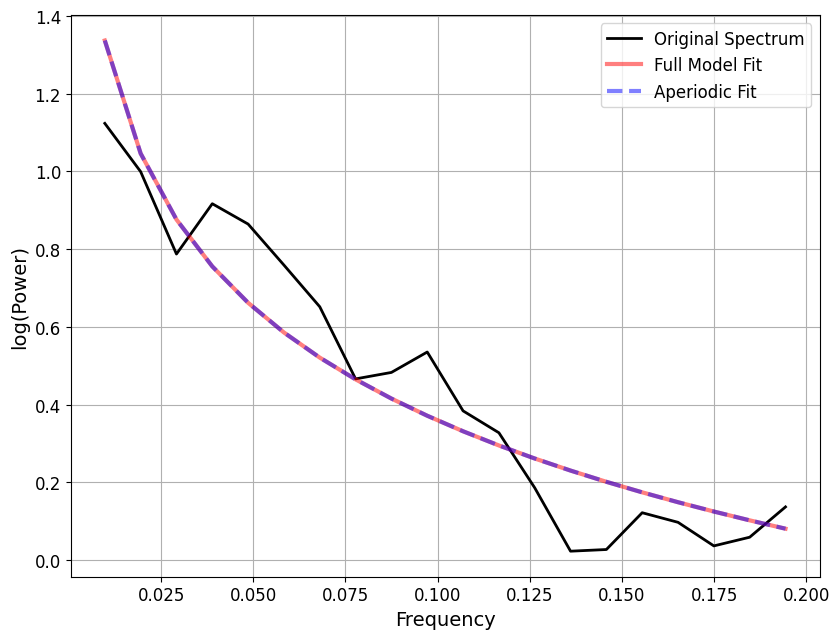

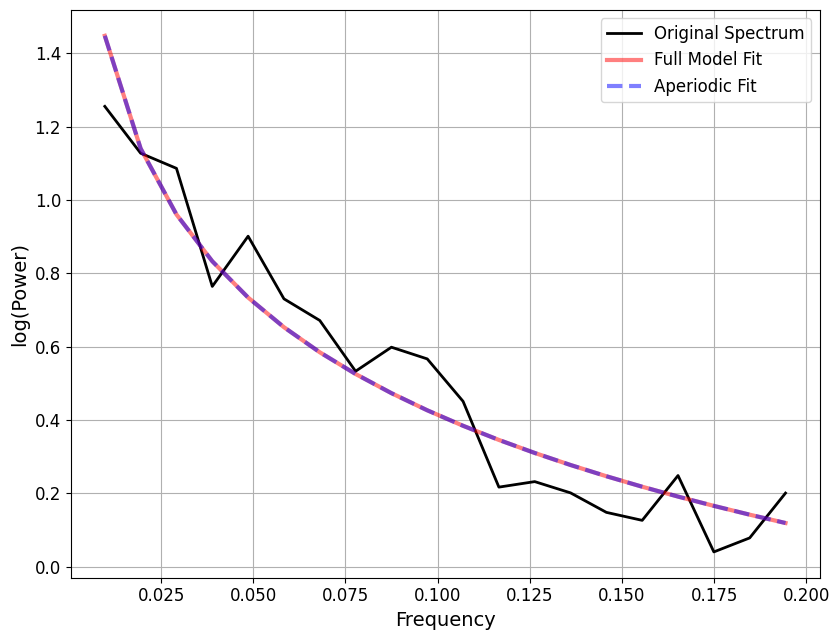

In [5]:
def display_psd(low_peak_freq, low_freq_power , high_peak_freq, high_freq_power,spectral_entropy_lvh):
    # Print calculated features
    print(f"low_peak_freq: {low_peak_freq} Hz")
    print(f"low_freq_power: {low_freq_power} ")
    print(f"Ratio of low(f/P): {low_peak_freq/low_freq_power} \n")

    print(f"high_peak_freq: {high_peak_freq}")
    print(f"high_freq_power: {high_freq_power} ")
    print(f"Ratio of high(f/P): {high_peak_freq/high_freq_power} \n")

    print(f"Slope: {(high_freq_power - low_freq_power)/(high_peak_freq - low_peak_freq)} \n")

    print(f"Entropy Differenc (Low -  High): {spectral_entropy_lvh} \n")
    

time_series_1 = [0.0657951208697149, -0.43448153506628295, -0.34529483070897027, -0.11669060652195629, -0.391418747050596, 0.4448798957711794, -1.1094229629344923, -0.442180536040608, 0.6023026374320821, 0.806618634235789, -0.3756755511476358, -0.535181827444719, -0.12708221030965863, -0.032132926270145946, -0.5803607832404303, -0.9553274466853439, -0.6135354567383292, -0.2299434889912087, -0.3137319877333295, 0.6486310805031428, 0.782359530612062, 0.019259183442320707, 0.7234934969442901, 0.36643448045810084, 0.00403247012928605, 0.06384856254497888, -1.3290465790132693, -0.3187964140364622, 0.46278691384094933, -0.21594118750029032, 0.329229592638774, 1.223257963862963, 1.3365397547177602, -0.07387966828416721, -1.374869492952301, -0.39964376853737693, 0.4929056463589207, 0.5883509210731878, -0.08839289380288703, -0.21699387895638322, -0.4400229127842051, -1.1647769205295073, -1.6747420536900173, -1.2641515949555262, 0.10090510344563032, 0.04589265171882519, -0.98770726706721, -1.293431315075757, -2.9979407896395895, -2.8222457678468924, -1.4335988410985088, 0.7571636633227078, 1.028943259191501, 0.5630605236632634, 0.32437621657572874, -0.3722335550650465, -0.45044813817363655, -0.9269041219668256, -0.031361977228437234, -0.2434247023217091, -0.8201165445807045, -0.5136801498182963, 0.5200226755454879, -0.5005903821546208, -1.6149128384691929, -0.618014533014558, 1.5691522942571399, -1.575273927224263, -0.6891398250544429, -1.2258897609443316, -0.7001641104970526, 0.4801422738046819, -0.041481734267268415, -0.5631779961296043, -1.2475520777950513, -0.8378159067195668, -0.6512622624580664, -0.4613427620997415, -0.8166840049643933, -0.9325601180370016, -0.6684892195180222, 0.4936677711578926, -0.4360955090699153, -0.4179322118022353, -0.6959217216778412, -0.43896971443388777, 1.1710956098641172, 0.5774485755927427, 0.6647255876859509, -0.6444393373976491, -0.649826345889616, -1.3309620584433857, -1.6928279000373532, -0.6130587748901595, -1.1732800239494743, -0.609604660364405, 0.21038260390507613, 0.16634440881978427, 0.46115462146882596, 0.8536362891661601, 1.2699534511812747, 0.6067171534172455, 0.8694699850333593, -0.6373003903690373, -0.8936487749814199, 0.5639410740909665, 0.17108766139463213, -0.08820361400726026, 0.21854038858958919, -0.05328593802698893, 1.1792948616991556, 0.5565314619698069, -1.1892749674937668, -0.29134325416277834, 0.20387762921393848, -0.4963618569128684, -0.26653904342018664, -1.386372582537673, -1.2000313079735598, -0.33853403578381935, -0.47151079694853215, -1.2049361547210606, -0.5138782407099168, 0.8747374013079194, 2.4505705530312265, 0.8976108120766172, -0.9055385008653448, -0.23470186091888304, 0.03388076143730633, -0.5477543452262172, -1.7745064596591478, -0.5527903309402344, 0.6053204309932906, 0.3766640820260533, -0.6959916929747659, 0.04090443890472091, -0.5143500438491648, 0.7943135460675393, -0.5928455234164177, 0.9903042448339676, -0.026264477398326776, -0.4553076756495775, -1.1793862777976802, -1.3231354453251059, 0.8887510849246204, -1.0928149139295682, -1.3753435051805867, -0.7342308253230838, -1.2852864144342766, -0.9457903269046574, -0.480296148730896, 0.2079209734487133, 0.09073470747980032, 0.5293455118202979, -1.0875691762579192, 0.5524356951497242, 0.7548013267846543, 0.505838639957042, -1.1960511057676306, -0.5849223671830989, -0.8558009570082445, -0.6386485582753554, -0.7861923487846718, -1.293579470019433, -0.9231015436724116, -0.13637383993498617, -0.03477599498034039, -0.6448972212113716, -0.7184982401305026, -0.34561696649065043, -0.05071163439102034, -0.4127602565306537, -0.5662625890733024, -0.5392008912436514, -1.1033350050709239, -0.73878365319229, 0.5858289742248938, -0.5461228562460982, -0.1420173262404231, 0.3464061364625656, 0.013356416880644515, -1.6450505801846704, -0.9748856628975173, -0.9473613805919976, -1.1780113802568284, -0.072766585367361, -0.654550838149939, -1.5672163597230364, -1.8472234522151834, -1.436270676607088, -1.7518593694931708, -3.0763469778933086, -1.376636523281906, -0.8121449738301998, 0.5885620329324359, 0.7030212085376605, -0.345711370195687, -1.2055057918684184, -0.6119838019160575, 0.3200260488195909, 0.3702049106550252, 0.12674036682394332, -0.1188596231111429, 0.777758058892813, 0.7895044000079876, 0.7361036828449357, -0.018853984191521574, 0.7605101328217251, 1.5126428714944178, 1.9575734230729487, 1.4831028024672428, 0.4092359719893559, 0.9251583996071817, 0.9358631296083247, 1.8508283342537943, 1.2254775202425936, 1.3452522421881656, 0.3510137497410004, 0.7965002696381452, 1.1916529577727348, 0.9482134992097406, 1.4820440735210922, 1.8649519781726416, 0.6008490448269728, 2.1264198613086296, 1.0755130475064494, 1.0033207297749995, 0.9558227165871424, 1.1211923793463543, 1.5057396442690418, 1.691856142041202, 0.9043776065198882, 0.875966140777531, 0.3725744089401129, -0.7624432776925184, -0.6599071400708515, 1.4087338218111043, 2.144216747504684, 0.34326153411261223, -1.8669815262707135, -0.9392438938250263, -0.8793637959921332, 0.034041104176982515, -0.5245123225362796, -0.6717966247128399, -0.7825867800249859, -1.147551391131539, -1.58984558543257, -1.0007652281943191, -1.951279720260527, -1.729901621083313, -1.2405277553569922, 0.33821334987941654, 0.17493290883806706, -1.5450633760636054, -0.04530998200673338, -0.6398073646547979, -1.0106452224286138, -0.5458499945401459, 1.0644829225412706, 2.1362004368475604, 0.9171812938980233, -0.03952030105016484, 0.6291006265835022, 0.3084823273614566, -0.410314853116189, -0.5962827801189017, 0.34773827626518594, 0.06155477638110595, -0.7219406175715964, -0.3505424507178736, -0.20935622064807352, 0.3984698488154905, 0.8967983715173083, 2.1383837701967936, 1.5899575891632465, -0.44705705568211906, 0.884311607176626, 0.8031310548569155, 1.226887042285949, 1.8696727223577678, -0.5097614168862586, 0.3517013606028352, -0.6730343052290639, 1.031837971457204, 1.1893323037283625, 1.092586180543783, 1.7141149612023163, 0.0825945919957718, -0.5534520563250133, 0.04964307354094059, -0.14032033057358115, -2.33332991862103, -0.48639671994088923, -1.21978728118758, -0.4532183222925406, -1.1492468419276272, 0.27683202589972133, 0.5959359485395532, 1.093641295725092, 1.2235012056260468, 2.1448516036901215, 0.5478384693254948, 1.3335183362621725, 1.5968095379783604, 0.4481502521618424, 0.742450787673009, 0.976235500993618, -0.3392981874992716, 0.05416216124114868, -0.39204072191055006, 0.0025379304801071336, 0.2911704290744401, 0.02277994412048817, 0.24241274652386421, 0.14266244061604244, -0.3786743529517618, -1.4276205115392282, -0.7171559589799997, -0.22380038155267087, -1.8032685017505177, -0.8880006507652876, -0.7220987278961462, -0.4403328469536697, 0.268095345186491, 0.4159829662239364, 0.417367056414768, 1.2555869361252279, -0.08226349302427223, -0.5775200584129494, 0.6231056331813429, 0.766883651044246, 1.5907074461740391, 1.2052371719501636, 0.5239402642198788, -0.06562195118649669, 1.155334503395779, -0.3672730381177699, 0.8815585364354025, -0.9656270957445356, -0.24154389266242518, -1.3182494366558433, 0.3848111903335281, -0.7808966902967918, -0.7186225514812423, -1.1850063006916072, -0.14132501158875532, -1.3407828138656093, -0.00577243357177394, -1.4509264024541586, 0.9391760754121177, 1.1033934295804053, 0.8945647851699606, -0.11054362249207465, 0.8936105638331555, 0.17329786957509652, -1.1392896037481501, -0.7765759506442251, -1.8310391047693981, 0.061607848868773595, 0.3684401730721727, -0.14937424211291356, 0.01131401722127808, -0.102801244530431, 1.037848010617103, 0.4072798595761157, 1.206610873592877, 0.4037360589987594, 0.8790343497364181, 1.094859732060361, 1.0334376711233797, 1.2891820382426267, -0.8710972315958457, -0.978010128261485, -1.6550995978082057, -0.9958220846487577, 0.01254322545495483, -0.5647812398752236, 0.2960995482357851, -0.19843449301192562, 1.1537966043974905, -0.14836472445795743, -1.8731891660854294, -0.947279348293342, -2.1776801292048, -1.2294548195421828, -1.3599681715479357, -0.44478539172211773, -0.38237826604850256, -0.14886671432905446, 0.43508516695889915, 0.9780642260614585, 1.4950682977839842, 0.6082127093898246, 0.25603808857455884, -0.1097649726783368, -0.8510673603308141, -0.5067357849041446, -0.08467551436819956, -0.4225721272015927, -0.7349989858161043, -0.8297711680783307, -1.5724372241110456, -0.40724052571174996, 0.8593333871082898, 0.5444727372338094, 0.6289975386673549, 1.15718702698736, 0.3747866908349389, -0.2885677793210441, -0.33126497993078885, -1.5188329629768087, -2.5506957632348253, -1.6607067902991353, -1.9362643871535077, 0.5661354022145484, -0.6381901386113451, 0.26464230243514525, -0.37949615014076077, 0.37530871968968305, -0.060574623461821804, -0.37426935872316647, 0.9684467730810165, -0.3418976763233894, -0.030247049570725826, 1.7183543035961235, 0.9697963497568406, 1.3720757161092016, -0.7322116021819772, 0.708175670422193, -0.5258602771364188, 0.20133254579103993, 1.376658778939885, 0.4667532878907915, 0.13383491876274042, -1.0016118949909951, -0.3984612716324235, -0.6464720394600997, 1.6789651516469157, 0.9964344415776824, 1.490317037097712, 0.40767441591529313, 0.7491928706239217, 0.49575515556619454, 1.698250141359116, 0.8272724400827536, 0.9524229340335748, 0.7881478253998314,0.14200974521518628, -0.19792371188434932, 0.12953473279377464, 1.3327571344451554, -0.34561211293953104, 1.6036332628535788, -0.26370733235373467, -0.2379163402972367, -1.7534498617324241, -2.402886257965059, -2.1579047605926287, -1.5852109557225142, -0.4439522545212686, 1.2773816863939056, 0.19042560067152497, -0.7975847584701918, -1.52160339893747, -0.75232343120924, 0.0344097607629035, 0.15714442033932452, 0.6218025687035232, 0.16843337088892552, -0.4079235296551113, 0.19476160114678936, -0.4046335203898023, -0.7193918233608362, -0.5437285394942242, 0.6078974203899468, 0.04765021883065698, 0.7136062342326667, 0.4120666288694571, 1.8504322210288267, -0.057563369055325164, -0.4521050730055504, 0.06399666711852298, 0.15682585192889287, -1.230983787106177, -0.551245265577051, 1.1996212914248412, -0.06375304569798645, -0.17167178238978734, -1.4444383362178372, -0.853560016535926, -0.8346580985533613, -0.5831931423615816, -1.3788503757410322, 0.04126233147156914, 0.6454689067099257, 1.894990420878002, 0.1286706631375747, 0.43473760874773565, 0.0481001575669061, -0.5184171742404303, -2.4097742437690064, -1.04005611541882, -1.0547445885794424, -0.05219518110166439, -0.016084469311757766, -0.49031364012396506, 1.1158710705917445, -0.4918111969964977, -0.7132305302751826, -0.9281242610951358, 1.0376877870681847, 0.6412722270618235, 1.30619037534843, 0.8109512796287488, 0.2609960504318634, 0.6473359616838561, -0.24652889711647544, 0.8284864819546273, -1.249933307235082, -0.12256541313720688, -0.66408881901513, 1.4820760181493426, 2.3090588178312514, 2.645806441063598, 0.2957997518857282, 2.09398375345258, -0.3016597672134349, -0.8830569546138467, -1.2769264503916216, -0.00037111252755662387, 0.37005113010766394, 0.3377077024892798, 1.1705818225649014, 0.13311072425460102, 0.26587854185787346, 0.447912636671544, 1.230073824039893, 1.3364516008689349, 0.29631743519535825, 0.14356368305888445, -1.6228818465257484, -0.37141803608090485, -1.40677648075924, 0.4811081477099909, 0.5285692857878316, 0.8188338565084423, 0.8528425088514854, 0.9200782844390314, 0.32992723111967853, 1.048781717870263, 0.8313874847429563, 0.6890343890848138, 0.7529981500884074, 0.7489140494733152, -1.3498797826305322, -1.0946690845391192, -2.663967851736767, -1.6170662235535562, -1.946933413410572, -2.142959575412099, -1.4862760789937932, 0.2671858265867498, 0.30931482586954556, -0.0004276970818417249, 1.600692919801463, 1.0383654786935845, 0.24053160330927725, 1.6597888667199692, -0.5948255947354029, -1.600323890018799, -0.5963871396841696, -1.158024059191092, -1.4929995151801638, -1.3618023783062103, -0.795385882659437, -1.8036003183369902, -0.7193099286612218, -0.8385506557817634, -0.36021456010182124, 0.24596198893271298, 0.01769576429481824, 0.36148634599559903, -1.2841497485538975, -0.06858475555727186, 0.20052728858511434, 0.37377838127468543, 0.9462584451221936, -0.5726416412231518, 2.3757671223011774, 0.6152740096717755, 1.1161722647832435, -0.20353343582317407, -0.07429399695171396, -0.3134762929501829, 0.24892039619073597, 0.4803042910112663, 0.3848924750327028, -0.1659840855495237, 1.9753686541225843, 0.5404465247112588, 0.8497299076723335, 0.3895425013053833, -0.44388948206150425, -2.2785333876747655, -0.9394235843067227, -2.400818780316348, -0.8097915062817764, -1.2491738562675279, -0.22263040325410424, -0.4214835778572932, 0.24479121404304605, 0.1509228360435329, -0.005169576954087374, 0.5383224121973529, 0.43377172293481614, 0.28842397021986144, 0.7087967405150131, 0.8516592918836515, 1.3025197271838718, 0.5996288413879614, 0.23694760053032318, -0.1877147770740613, -0.005881579748063167, -0.0614449721777562, -0.4974590687558781, -0.43509987332396255, -0.3566469085406031, 0.09944530840732363, 0.05174945472809165, -0.7694395931926, -0.8554681524439175, -0.6163666630647429, -1.3222008788124964, -0.27855279802262867, -0.6855016950387129, -0.417913949828388, 0.22277060293694775, 0.028048762207638987, -0.6135098056954886, 0.9078132835352132, 0.776772132554782, 0.893828734922216, 0.6801904585478261, 0.1643959610817043, -0.4147118620734778, -1.5548040429692374, -2.271299082112238, -0.7491035248935293, -0.41947513131436825, -1.0931157423215263, -0.5239021382976237, -0.4136934711055512, -0.3937735805265998, 0.7704855352008749, 1.0938396053793764, 1.285298342920529, 1.0027867265395254, 1.4385644613650639, 1.2168920002790882, 1.1955580629477829, -0.039111412901494794, -0.6061865512427903, -1.4848136781988206, -1.2342403617407367, 0.3816881432130307, 0.443880077706796, 0.4895177046587639, 1.2367615544616135, -0.010797186317924387, 0.5341649999039293, -0.04360034562564659, -0.24525508038199975, 0.07715438045863822, 0.6515893722704826, 0.07790619657728774, -0.36570174545582623, 0.03632691028593504, 0.2790953948329691, 0.8771030775635907, 0.8910739596602949, -0.2548283710058663, -0.9504536557727441, -0.8826719039771012, -1.52706561392832, 0.4325116621066675, -0.8097070109589867, -0.560042912065957, -0.9451438373441933, 0.7409559758141369, 0.05397145914426984, 0.3019485000483353, -0.628926299476752, 0.22000998636123767, 0.010783997182986501, 1.329251344290879, 1.0714022094778648, 1.7995502188207189, 1.412862447644295, 0.25360118875675564, -0.7538926718292257, -0.7762521689623479, 0.4626908538139818, -0.14407978602120997, -0.9129654515392301, -1.2019785480325598, 0.008658820135805202, 0.14143573572657916, 0.807546087219844, 0.6064980689333451, -0.9222224099716366, -2.084381197053428, -1.701321163184456, -1.3532997713050041, -0.5688854729220536, 0.0023990876510114403, 0.09141509234337847, -0.4480032944254778, 1.356710844301416, 0.11014602836480893, -1.0224947649849883, -1.6046322370885406, 0.5181658044955162, -1.0209297433427555, -1.5319693876403726, -0.3573961634597434, 0.36223687575221025, -0.026817312797129674, -0.03467531102285181, -0.863348581778837, -0.640022137366759, -0.9479529791651349, -0.850730467098314, -0.14552785348234415, 0.45459295044632575, -0.16182362573908643, -0.5591494754276983]
time_series_2 = [-1.2078718966403272, -2.1144288637947932, -0.8544435257643608, -0.023588482876719954, -0.1784756289051962, 0.5034937168298238, 0.470904803334113, 0.92461939160382, -0.14787347618283178, -0.8165548314801827, -0.07207518972325164, 1.1383391247732764, -0.9792614852941224, -0.42311343889206976, -0.49386477748214236, 1.1316891607592259, 1.3284843137812725, -0.7437473812717723, -0.43339943093036803, -1.0005639721114223, 0.7999079548794931, 0.24948456229256247, 0.9616633900736268, 0.5008389383475068, 0.49030598349521576, 0.8487026554271039, 0.645627135827703, 0.45751523887803336, 0.41365998742679294, -1.9998170831822495, -1.041632596689644, -0.5508455593492075, -1.2198396764831647, -0.14559280461975346, -0.5307566202192833, -0.8830769067866882, -1.424671269676289, -0.7324465824036543, 0.2996573248149392, -0.4461692331909446, -0.12842482386417708, 0.235071140331322, 0.4489577123032088, 0.5555639393680776, -1.0280002605798646, -0.19530716478635332, 0.14833217917491368, 1.044445480774064, 1.7618170684344516, 0.5578746168353093, 0.29597982469404155, -0.11421858461809528, 0.45146255095094734, -1.3593442950647106, 0.47368441226326274, -0.7278030551525978, -0.3102630232494429, 0.3164731910649586, -0.27287137871856376, -0.8920524262563834, -1.688611900618767, -0.0674751733417749, -0.7596429560661462, 0.7346825596038159, 0.38830077146370906, -0.781567521229418, -0.7171923018135177, 0.011874770869993377, 0.05361792779780517, 1.0261718564921527, 0.07238401253365634, -0.1644472219747756, 0.8552240658744014, 0.6098482964002464, 0.6443784278424705, 1.3943437185562544, 0.39390955854146814, 0.022787464657272744, 0.9088671940219397, -0.3947673346804088, -0.3850094097404846, -1.013617969975051, 0.0732305082774142, 1.213265110417857, 0.9410518628725609, 0.5447285601714122, 0.9125148282928447, 1.1890431425402186, 1.4390448522841215, -0.45726630019926107, -0.802347480531455, -0.5647036090927583, -0.8754687415897848, -0.7894961695051644, 0.6082114338040385, 0.7238899291560216, 0.7596199673115631, 0.13128616079011607, -0.27528641043624263, -1.1694013830533152, -0.1826270274481703, -0.012000244827952627, -0.3011265980920804, 0.5054541343590184, 0.19266628490935817, 0.5964740090715612, -0.5690538414105668, -1.7315630141005616, -1.153289987020315, -0.28027782707107446, -0.8483059478315869, -0.3908161510256025, 0.23578057885392462, 0.21659170498911648, 1.4888546840661487, 1.8356219223098478, 1.4756979169972506, 0.4351253970102969, 0.6759056693351903, -0.9641878383167453, 0.2299222519251429, 0.6298692672040795, -0.34956693212438844, 0.6184798093509317, 1.2824369447461177, 0.06276953479147815, 1.863429357528736, 0.11385876088180055, 1.3054330324055243, 0.118158516851951, 0.6666264989585724, 2.1423828920215997, 1.9283006635356579, 1.4003046299025448, 0.8610635217867477, 0.5249136915183851, 0.8175783075394296, 0.603159123679554, 0.13618922620785281, -0.33098309596876374, -1.402239152671713, -1.1996505183421395, -1.340746446342711, -1.2072080341546485, -0.5363019239726239, 0.36383835351213467, 0.11680330515216245, 1.131747700297409, 1.4506445865209425, -0.3127445867610745, -2.0826908779174578, -1.3222480851247467, -0.6612305442917212, 0.9161354634763177, 0.09073018213949785, -0.9042351670733346, 1.3111309783086378, -0.008018941500162474, -0.5660910511568851, -1.0336213757426846, -0.059236666076637495, 2.147148738415677, 1.0277637712464218, 1.4658918882951895, 1.0491015589704955, 0.9939738803075748, 1.1304566966766905, 1.32747158443947, 1.0972100181838, -0.19951842241638915, 0.3851739038947857, -2.213329223082008, 0.017198336377292688, -0.24596036452879458, -0.5023830363738623, -0.4146083283699047, 0.6038819877238224, -0.7231321484659574, 0.6551611940863848, -0.4589553408709961, 0.5811610172184392, 1.2102579338500654, 1.2913548425491357, 0.4776306015451449, 1.824428941512752, 1.6427072289176678, 0.8434688027217064, 1.6194638666491663, 2.194559849414013, 0.18027483564791502, -1.6311397227045352, -2.161872993881498, -2.3819252002234736, -1.4222855806827441, -0.10721350743196319, 0.6153995323932567, -0.12298626699781685, 0.4833149823167776, -1.5147762284882498, -0.5513077017890509, -0.6845850786838014, 0.018547139133228384, 0.9416383848125692, -0.4026212644799815, -0.6687158816687556, -1.5786680438778586, -0.37059299217345054, -2.7728877407547623, -2.506947193419152, -2.2518102780664018, -1.01119877745456, -1.5230774690279276, -3.0952296202747394, -1.7385244630224042, 0.536801166220388, 0.6945333174418248, -2.247887279854072, -0.15741099468456138, 0.8037026424212329, -0.17736887751900365, 0.5115102136425606, 0.961029098085065, -0.49030974140716815, -0.850686669181139, 0.7910485701284663, 1.350126241701079, 0.9415911425483163, 0.07796111123126057, 0.6409542335103542, 1.2520703329685399, 0.9253301021587246, -0.050341241905598404, 1.480587856848666, 0.04918548638768442, 2.0757141616033135, 0.9821315925908352, 1.040297569768816, -0.20715034253479891, 0.2656877846090239, -0.3635501981421667, -0.10507524611371225, -0.7481171208891558, -2.4043752761863666, -1.8873577384641114, -1.1983454511726053, -1.955479005295986, -0.8983025923225071, -1.1822840718962315, -1.0106036918872434, -1.509690451537267, -1.6414522571722017, -0.9218062116145974, -0.2789924570704181, -0.12965350209470414, -0.4471693777823799, -0.18135005779172014, -0.6462250857840673, -0.23735770312025942, 0.09314529794446096, -0.8826267512498567, -0.7612201615816324, 0.47578647681136577, -0.5459700919598529, 0.8126002321739175, 0.7673609568009374, 0.9487940301063216, 0.2878309917951153, 0.4746887853713722, 0.009300791348878113, -0.5471747393066739, 0.3265863319583866, -0.7357690344693332, -0.32232491101762806, 0.9011577958766206, 0.6187232132255194, 0.3532116411794231, 1.92644831687566, 1.2593319043820983, 0.5768557191443149, -0.4952521581737463, 1.4893591273792752, 1.6445501396182334, 1.2536719527252014, 1.4481225341909743, 1.8721029657075225, 0.8533705653154242, 1.6787361628168738, 2.52497212077085, 1.233676264242165, 0.3442947737659769, 0.4920599400176786, 0.13891001304046074, -0.32518708398321944, 1.536991588788956, 1.3810367769916343, 1.619674370674852, 0.403875493161407, -0.9421667781506098, 0.28298023331047634, -0.3399935630093817, 0.9614057300156245, -1.675157744164648, 0.20849968594907947, 0.8796791307247779, 0.9866542176722599, 1.1676430590765408, 1.2947955608625192, -0.0173573439573742, -0.145842517634863, 0.5038018489832519, 0.7195618198941452, 0.6505199912089492, -0.9104037855393459, -1.1830148111005683, -1.5044230324206627, 0.1789863631212433, -0.20451104636096623, 0.37821342787006434, -0.48952175782364943, 1.0406194512492637, 2.191082359229118, 1.4781245231972118, 0.7322296996201134, -1.1723080812201057, -0.5854171514015658, 0.5503930478379836, -0.7507797972926487, -0.5186944026454915, 0.42787953226400494, -0.38789688396135763, 0.14217545400811624, 0.48777857170633643, -0.15450572794955136, -0.3575541229439676, -1.376912670743599, -0.7514846063177074, -0.7065896704549406, -0.053314039279729594, 1.451446661371863, -0.7275273840637294, -0.9666752444926406, -1.4970447764627346, -0.7306436694748237, -0.6559489520001477, 0.3319002495928373, 0.1962296176829065, 0.599740385188864, 1.0609665774428754, 1.781202865760282, 2.1807461284273675, 0.840189205110065, 0.28115947467128377, -0.7119191307564772, -0.4061735168125987, 0.845096130632853, 0.8155383176664516, 1.1400510152751797, -0.028879070743133825, -0.19066328561147308, -0.9390119537077145, -0.2619958026041214, 0.692946543400739, 0.4551526883427862, 0.4085090574183304, 0.34586683563294895, 0.5916636722467351, 2.4406542177690453, 0.7592085911757914, 1.8386671707954532, 1.0022428388445714, 1.8028626996006316, -0.1674113180982436, -0.6474988739452701, -0.41505809130590243, -1.0617162456404254, -0.16075154349877818, 0.14908417821335987, -0.29057200701862057, -0.36587604154430065, 1.169949198459109, 0.48534986471916286, 0.35861587523364713, 1.9965352229780566, 0.5757432043381778, 0.8577333130836678, -0.33853348074820144, 1.1674063759884368, 0.5133667040917499, -0.3019938171001422, 1.2495043219239792, 0.1595132047755213, 0.9432029442725992, 0.9565068012335454, 1.6122258514200307, 0.8683034457015755, 0.9735908812044044, 0.47634500466548446, -0.15548929723681407, -0.06162349762855436, 0.29045788028442293, -1.498443864929074, -0.12393701657174216, -0.26125750357490046, -0.8864385999655487, -1.2674983298213052, -1.9923413541963901, -1.204056532219684, -2.372151255836569, -3.278335648272915, -2.567135535533297, -2.582073636300878, -0.3464795134788857, -1.2671735199062488, -0.09623501256754408, -1.6788571754721038, 0.14564889816096024, -0.4255050541964233, 0.5994463914720582, 0.2935547345410968, -0.947272938928878, -1.1976059937865295, -0.7386047495765823, -0.7853707524463329, -0.8751016632276717, 0.08493440790350228, -0.314754437473056, -0.19389743611101942, -0.19085021419001436, -1.2021304549552938, -1.832709731766108, -0.09792261961097566, -0.5541262617231094, -1.020831703155594, 0.1404046605555483, -0.9381773463410923, -1.6322732451511373, -1.9901373269601876, -1.7538484551136866, 0.41859647003275197, 0.12227223498000478, -0.2153229009566487, -0.31821965285304243, 1.3539193654073978, -0.37096730555609086, -0.4072292305032087, -1.2138039942004946, -1.8027961846964529, -1.2360618497690647, -0.23234771133166007, 0.4089204112400534, -0.7935954905399891, -0.4382780612942187, 1.476769637613768, 1.0908730251308414, 0.39820471264221863, -0.46659929553782564, 0.23678888392164008, 1.1820455299329606, 1.8836203670701317, 1.722031074491172, 1.9708222639258393, 0.4359824162400051, 1.2979467616235703, 0.9480237408728912, 0.713537313999595, -0.6784895547491743, 1.1089306560504424, 1.981893730889365, 1.2250286681276195, 1.2927905318177508, 0.5072560342317392, 0.16688137586149787, 0.17749441691076928, 1.2586347678491674, 1.0292215711225006, 1.6089699130387507, 1.856473704617956, 1.9512578413130315, 0.6921015110985153, 0.9485639172812383, -0.7201937762282252, -1.8112268777021494, -1.8685272859059827, -1.7034662426440137, -1.4097177198109239, -0.1666148018860165, -1.735201947120408, -0.7480541923535328, -0.4763686041943318, 0.4914825694132092, 0.26536564353538034, 0.25071419518429855, 0.7412358009480535, -0.7832534481125183]
time_series_W = [-0.701788559595255, -1.7761294370471525, 1.4681169834213015, 0.1009750172217556, -1.2279310685195952, -0.15962591559147363, 0.7332243729834617, -0.5450408852129436, 0.9972761465450172, -0.5255268246625522, 0.07095347037970956, 0.17862520561395756, -0.7258639659529789, 0.4700437599429996, 1.7599867649111312, -0.09923956731970851, -0.5305289901789418, -0.2791976610438386, 0.16214548921374508, 1.4595990878401917, 1.5117561902980396, 0.7045033942528218, 1.19080683900959, 1.7318938117989595, 1.4810181745579136, -0.314971452820653, -0.17886225555227842, -0.4661655279294966, -0.34491997805217584, -1.015784932726747, -0.7351764444047036, -0.22702031482392854, -1.5093582722124286, -1.419490059249135, -0.05797408596774832, -1.083012451929342, -0.6815194185772533, 0.8770548046297766, 0.2114454679034076, 0.48477750097817623, -0.2758083062947689, 0.6847604575377155, 0.43367984117843755, 0.22711424741474898, 0.19262773231591265, 0.5481268940675482, -0.464945116187102, 0.09396724899830225, -0.13053670379262342, -0.1245107804089205, 0.16948438986777925, 0.15533449332119642, 0.06205758286190625, 0.029509965583484787, -0.642714019163992, 2.71709976892069, 1.7112966541209291, -0.010343961203861943, -0.10803484236739619, -0.5817291905063263, 0.2253662485323474, 0.9507540298778632, 1.503423951803148, 1.7651543752869623, 1.5302134332702881, 1.9099427071088804, 0.8840128221538627, 1.4199466551080009, 1.306446760807291, 1.1524679519891088, 1.0723462378606734, 0.8319448184954568, 0.8219346306078354, 1.0890560993633023, 0.1023175902358018, 1.1585598168166944, 0.9884727896085268, -0.008263347883772684, -0.3335653039328511, -0.09701486748188416, -0.4973996228099848, -0.4541057911912867, -0.8280871774432912, -1.218940940215575, -0.6730162515512487, -0.4439846846354367, -0.44242620837305935, -0.35072050272811983, -0.22642552674443886, -1.2089159188252125, -1.1510318247179692, -0.8671345118165111, -1.3869762497639544, -1.4000719689236134, -1.1965162942294076, -1.6727824226685848, -1.6299755636637712, -1.6654000741289248, -0.8478095528620735, -1.4462860444132042, 0.9762730733131528, -0.5792339635832111, -1.6533538028226014, -2.376150851407101, -1.3567298294455499, -1.1335602769237545, -1.3607007888651754, -1.4610042712483389, -1.6549056537579336, -0.0033261955971511017, -0.45604136293961073, -0.443340698188524, -1.1020497361646808, -1.7099700439997605, -0.5544331504257773, -1.2039488960682725, -0.4076364380904089, -0.9890041203742973, -2.0841043062977773, -2.043143545243082, -0.798378755203393, -1.4868897995732806, -1.427962127367036, -0.028065674292884632, 0.17121492718616352, -0.4407470381961957, 0.3481674714578079, 0.37984817423926015, 0.5804954101922308, 0.3672825268503279, -0.06175474752104505, -0.44664381792862734, -1.3954053836576918, -1.7636537007575843, -1.7389759586694815, -0.8865763653748878, -0.41102897251563725, -0.8703399550942718, -0.32760531301241225, 0.03110520610456088, 0.9366331487965786, 1.4091073541649124, 1.106377647907628, 1.4075320886963107, 0.7176934390034502, 1.4531405562530364, 0.6328643281503368, -0.3633346071260785, 0.6766814222530577, 1.3947811608085599, 1.975544491171816, 1.6184102032757266, 0.5944472349748763, 1.7255744538103956, 0.781591908614869, 0.9686445149383102, 0.8824599018216517, 1.8326007082189326, 1.2426221604104477, -0.32649156356713, -0.4895935830737561, -0.2810318194832462, 1.2715119280529883, 0.8966933794412802, 0.5333619883740052, 0.11500240702930599, 0.034693477259469606, -0.07271563973370963, 0.2549930231275765, 0.24033839616753766, 0.9117720624155172, 1.1407184940798865, 0.4945904785978557, -0.25508386840533803, -0.8078107700584308, -0.35502466678280936, 0.25693835943659704, 0.873871717631002, 0.9612873425326969, 0.6826522357134325, 0.6238808281918785, 0.41155413847178784, 0.6553360377661338, 1.3802770867072416, 0.5904645206743604, 1.095947903445896, 1.1508778064785565, 2.101778870496507, 0.8483292812400572, 1.1311530008327648, -0.10185815385364358, -1.3129371035234516, -2.4022346788946747, -1.530762269915285, -1.0598942778496794, -1.1575512094466691, -1.0155067890428533, 0.30121264581085677, 0.36090541681163135, 1.2623318352008521, 1.7180240230518768, 0.5354557558930011, 0.4054659854941584, -0.33289922809845335, 0.14708259890857156, 1.5102227912243682, 1.0734520998373478, -0.7444746496134571, -0.7630813177506711, -0.4268844013015345, 0.5535463887703032, 1.6233491545085517, 0.8253989531412856, -0.12405430446858233, 0.1982231558486641, 0.015157583679947254, -0.3281691518266563, 0.34369230940810674, -0.7128778097233102, 0.43524929571052856, 0.15691861779361257, -0.7292973772033295, -0.4844865637120717, -0.2654530423705181, -0.7499817779960094, -1.055952568287346, -0.6577514104245342, 0.15601578935618823, 0.1974627239817221, 0.4127982654719105, -0.03807899246821363, -0.6335994059556874, -1.6210525389130142, -0.29684027835545396, 0.2474922969182858, 0.6294238222009458, 1.799750041223014, 1.6631767967097102, -0.1301494521798333, 1.7820218546105775, -0.29546845778897823, 1.5811390005397299, 0.5400577832199367, -1.6440586762476728, -1.5794105909924043, -1.5201020848241726, 0.17020876784411443, -0.8820973057119006, 1.2979203903704697, 1.6528269492532561, 1.0692620353326918, 0.3591262577229716, 0.8418090559952571, -0.24441678480980328, -0.510135385402808, -0.5120938380729925, -0.1305433911661685, -0.016565758412481126, 0.40189449664076465, -0.3884937393131597, -0.1714322940697151, 1.9869267994863924, 1.8212584784173886, 1.6467846753121915, 1.168692659116312, 1.6568345956835362, 0.28511375831417207, 1.3927105495938796, -1.080705157606896, -0.740413090211625, -0.02488737524958292, -1.4946410878505223, -2.98993714604379, -2.8965260868760137, -1.5657678143606577, -0.21393756329766908, -0.514267237609349, 1.0806324542469405, 0.5875183913828186, 0.01639489394691537, 0.6856959986358344, 0.8642008947583156, 1.3957275583828057, 2.974128302676443, 2.1545729164228846, 1.120943127727794, 0.7303886614744689, 1.9147459116463015, -0.28057913865866213, -0.43251815466214766, -1.211810377038807, -0.03905016924464856, 0.501667526449788, -0.8446695505310776, -0.3382773322292598, -0.2601710489392562, -1.1883092615362512, -1.6508110833540983, 0.8209941437872313, -0.13574886342924963, -0.378901352732053, -1.0146847253912592, -0.274742682409799, 0.04836387861671132, -0.857373914647569, -0.4837721996990138, -0.6123750523741587, 1.4330169146814191, 1.9229755813710918, 0.19618288876956325, -0.9112284731654952, -1.1252979252141735, -1.6198706302952703, -0.022605756836405637, 0.5398484341687514, -1.741710652742611, 0.5209671251040031, 0.8815229285779409, 1.619615314100343, 1.911937671887762, 1.104729597245438, -0.050947113877479244, -0.26728203098772657, -0.8219059102987465, -0.054373158022489584, 0.8658525721518636, -0.1286636941654451, 0.47153400199045387, 0.2654078302074374, 0.4051333969290596, -0.8073660799647231, 0.07695766938735726, 0.13815583737789697, -0.31383319803447657, -1.5664493057306519, -1.5880353621093186, -0.6387996259298306, -0.23928345997946696, 0.5400227082243659, 0.22894275690161428, 0.42441791444303534, 0.9742947890784265, 0.16575355386955093, -0.05013148882950185, 0.005476328766465724, -0.8645434167507896, 0.30278270243899774, -0.15570947020027662, -0.1794085000511643, 0.4377859779895844, 0.3656086130054697, -0.368925911048701, -1.763390232329057, -0.9217872764745421, -0.38662508301248494, -1.3466846455876247, -1.0423159629162766, -1.7740447764071459, -1.097792527071146, -1.9514111417613926, -1.9926014528192133, -1.135873241620729, -0.6180212802512716, -2.542265828303588, -1.1110845038851274, -0.04199311978194458, 0.1687501321508651, 0.0822652694384298, 0.8673887912259005, -0.7312149048685633, 0.5004852680914478, -1.4453663667900785, -1.2258996565166829, -1.8309626390051899, -0.09915465263902846, 0.06806403204392532, 1.0404364596436586, 1.2072094547956285, 0.8341942686656904, 0.6934197931412225, 1.6951543761770347, -0.08359784264635363, 0.43060524740762585, 0.03402657813397105, 0.4567161653822433, 0.867502074476801, 0.08801992945486435, -0.266387630821578, 0.3075433739038834, -0.6257722224733061, -0.08548107180897742, -0.9906406912161994, -0.02464289087785369, -0.814314597464633, 0.7687645992096747, 0.6382448622662471, 1.147801937897952, 1.0537121087585324, 1.6782793383971675, 1.2591067002592047, 0.2336494179894513, 0.6898197309435887, -0.3498212934976639, 0.36294467618873544, 0.5310801993350389, 0.02575968838255411, 0.7238569414781884, 1.7069708761947668, 0.8591173606217452, -0.7270462651322189, -1.5207773849273798, 0.7739039776976342, -1.6424983486738507, 0.2724316608956768, -0.23556362351492266, -1.4245968275863476, 0.19561795620961847, -0.5574555483030328, -0.2954184565254317, -0.7901788273524636, 0.3641078334207154, 0.20621661157341775, 0.8174711113480287, 0.5281698816835632, -1.9418997284722652, -1.5503658379746255, -1.4684060587714847, 0.018058000622014007, -0.6611359050660186, 0.047682866149376925, -0.43108943059452015, 0.26300081649160956, -0.10628251583396835, 1.5135839529721256, 2.4835223256669554, 1.3472254086866926, 0.6239743142333721, 1.5348791881890556, 1.4452598252647282, 2.0931012373459925, 2.2431734687513627, 2.679469770915746, 2.0544198936107683, 1.8636298493356938, 1.5153386644308275, 1.505160767839577, 1.8850978965190415, -1.0663959371040883, -0.7100144896207493, 0.11159068001571215, 0.6743121472330953, 0.8809730706657741, 1.2090481111464848, 0.3599672120539122, 1.1504090366180095, 0.2813182374144339, 0.6085314065834375, 2.1489459422129897, -0.971482562768694, 1.8879940584449297, 2.115547846600109, 1.9089762756965678, 1.9672025845328136, 1.2090105293869418, 0.5236900090321135, 0.5907689404300596, -0.4544499105125056, 0.22323723309660337, 0.7476878304288451, 0.7963777181410344, 0.24619736030186753, 0.4300206656040239, -0.9114318444910096, -1.8421801729056204, -1.39151354171926, 0.2601924150650803, -1.1140180726141415, -0.13243243437421948, -0.6788439704933658, -0.2961495875392786, -1.0667897445422365, -0.9142470974260558, -1.997624357675392, -0.6804081256441746, -1.0676587282501455, -1.2693466817887478, 1.5975679086135826, -0.21317700401433823, -0.3963005096375826, -0.6435155150482107, -0.187708240252295, -0.7602946616581208, 0.8538400873103491, -0.40935506723550397, -0.4316739838389476, -0.09471849075160688, -0.6162328629617656, -1.0597917567404036, -0.7454410701541253, 0.862093014631471, -1.3808454099056637, -1.6042419858744303, -0.4296508048043338, -0.35426547074081716, -0.3562070575424753, 0.16864565239501939, 0.6037566819416774, 1.4067595079934292, -0.05579098076609165, -0.20356847563315236, -1.1968090762083645, -0.916700252733378, -0.22009863473530816, -0.7698670550226389, -0.48494316294808915, 0.08054670715675383, -0.22606675245398486, -0.9242486635168262, -1.0884249560315478, -0.8296797845016818, 0.5731148632332702, -0.1681453772674423, 0.1077770950015048, -0.08656245054366953, 0.8441823108927431, 0.41044011021322796, 0.8662121794427861, 1.0133168404806687, 1.0676175339480323, 0.6541299006003481, -0.17729059120345123, 0.5724547471240119, 0.2351598820457817, -0.31172671923193956, 0.6074028734952461, -0.10623275442216758, 1.0935330821655778, 1.792480919226179, 0.9081500507305474, 0.635637337191169, 1.3556261170794779, 1.0443184442990772, -0.4607970698558359, -0.45019296880312293, -1.0401144012238608, -0.42078268439479827, -0.20254682918968459, 0.6878471288816372, 0.3016527034451761, -0.9153005134131629, -0.2824434557378726, -0.24226860981632808, -0.6585158601822403, -1.1759756085762616, -1.1548995050765407, -0.13098896834283527, -0.5743427963701078, 0.3984651906821451, -1.6503259123678031, -1.0311489149981128, -1.0929355711769089, -1.0577026430773027, -0.3689909229908738, 0.5636643938100423]

# [-0.6436901314198897, 1.06216207716049, 1.3592595181445914, 2.570675753777558, -0.7840740950079897, 1.5483123387935886, 1.5030688742148985, 0.721934147821553, -0.4721930935279792, 1.9476283813897803, -0.06302667495156467, 0.6256328495874249, 0.2971801934916477, 1.3534659134490419, 0.6847838491346012, -0.021246811244844344, -0.48951362517523817, -1.6575811892609513, -1.1684459249305605, -0.47857571727099246, 0.22178469090663236, -0.7211598649639362, 0.46039953940437933, 0.5842106423694656, -0.37727467976263346, -1.133222571331938, 0.3257795772581489, -0.9091390257009875, 0.61507788509018, -0.22181921682310118, -0.8678023505639287, -0.6587866726932518, -0.36599639946541174, -0.33421373659241604, -0.7445671339617109, -0.9425879450953295, 0.4238262708418927, -0.7303469195310244, -0.37541850599092846, -0.9651165155459168, -0.688233192514613, -1.4160108172302066, -0.8189240599404435, -0.34740511567265586, -2.2792060640190916, -0.35370675090756276, -0.08772037931708564, -0.2064002566237472, 1.0069207307355712, 0.25627968671241097, -0.2490714272567804, 0.06441866753942194, -0.2360331444788462, 0.013809903257917073, 0.3976042866409398, -0.6378678696962381, -1.548848516270841, -0.32232382090816303, 0.7878165491347926, -1.6007921218870302, -0.13388403731646492, -0.5615770931140726, -0.30375792109782734, 1.7503953426903134, -0.12810680084314982, 0.6913993830166785, -0.799340632348516, -0.7449655868199885, -0.3519130717404586, -0.6639029543259025, -0.3173707819296041, -1.2131339647057016, -0.21140010900356343, -0.4207824589373106, -0.23993114428854717, -0.08881133143658891, 0.03267744539783124, -0.41804641239365214, 0.2069253898421961, -1.1836105113680293, -0.11874242208741725, 0.3846370002935969, 1.0528486957730803, 1.28165801263341, 0.5051600315513423, 2.002408674738257, 2.208470589413078, 1.1180017511235367, 2.394092436896611, 1.5330501018423475, -0.7148090841874482, 1.3521225732040887, 2.301417604976624, 0.15415541953026904, 1.7337126674976344, -0.32171787573404076, -0.2923714994914598, 0.918700216661427, 1.926237001942193, 2.0574273905250955, 1.0129626011176707, 0.8277920269444311, 0.4510205384013118, 1.2776433691096447, 0.6404997944453195, 0.32548581141703403, 0.06342742156893554, 0.27211283331209996, 0.7720594175439331, 0.6749710734665421, 0.14069791399456252, -1.035317670581746, -1.707155631566988, -0.9163664720152136, 0.6950482882242198, 0.2698307694573275, 0.3212750775927151, -0.5824973608023787, 1.6252968748480754, -0.9187147344143216, -0.26624093844392743, 0.435203656568417, -0.33168630952791095, 0.5649883712174271, 0.975301509605031, -0.2068423248754706, 0.14220964742447803, -0.17094296536627088, -0.07976881678824614, 0.46078684582711604, -1.0023691682049085, -0.7243545512471561, -1.2841208043563255, -0.3363551449856894, -0.7746794623527471, 0.27242080884746844, -0.4901689219538909, 0.8020518882015548, -0.6185104696622821, -1.3804554011618424, -0.45958860784852046, -0.31802738527420144, -0.9354292081020781, 0.4135585068764095, -0.41711929443927853, -1.9388498583646752, -0.4231577257712706, -0.0170485416990774, 0.49650544578436223, -0.37544206814750036, -0.9677886026745136, -1.7582693868506005, 1.314782629342266, -0.3455901192454241, -0.10057002479836398, -0.3680638300562003, -0.4420741227677817, -0.47055439052950015, 0.43404878347313547, 0.6685602041572165, -0.9374687236361908, -1.0187019696221158, 0.1696017085921013, 0.9543132054223308, 0.14496475202590292, -0.6540188331058284, -1.3166620313691968, -0.0419310011173462, 0.5651941570853982, 0.2938014748445791, 0.17909251627151057, 0.8876988432747807, 0.9481503808680459, 0.6304277593393434, -0.5870933360350581, -0.14142044453874184, 1.103496179327045, 0.8105443799399386, -0.31126303588852694, 1.3760068446727605, 1.6261251217657238, 0.3347405807101297, -0.030316267223590005, 0.8132743751435545, 0.7483403244097198, -0.13444935930834317, 0.670476866716073, 2.162891985236163, 0.47194885756273264, -0.7628083523405216, -0.24531730019049588, -0.06782093004541777, 0.25440576396587344, -0.07276153546424981, 2.081609182043349, 0.28101356459789306, -0.5883826914555187, -0.5194955797736619, -1.2334132071707313, -0.46331983048106795, 0.21961576881981493, 0.367618074489257, -0.8938010673497842, -1.0335812183327169, -0.0704822469814697, 1.3722154271826328, -0.03477661304472567, 0.3611216537932568, 0.36040621293701813, -0.35138570945352177, 0.45581098890206334, 0.07160088256425794, 0.4325117059137833, -0.3547168540079293, -1.3152758079461362, -1.3957473343314692, -1.5008314072794586, -1.8663547500608104, -1.0074733379072773, -0.6688851936918314, -0.16313844517807813, -0.8422128346982205, -2.1272708577123733, 3.142696981316496, -0.8121011178110085, -1.2601804309749924, -0.3337872612633581, -0.8756640566256663, -0.0721626045920859, -0.34059138252143073, -0.46678111199221767, -1.1511535910415494, -0.507628367169016, -0.8539316779038162, 0.18218377795401094, -0.3563199035580562, -1.8598391834636931, 1.3182121872925932, 1.3412757576416003, 1.811874961347492, 0.8176987280512391, 0.9444480292259818, -0.12741945980278585, -1.3072204708516053, 0.04555812361452118, 1.9082951446672343, 0.41264667775707997, 0.24172308462305134, 1.098216574982763, 0.7149075046834742, -0.24044768038204328, 1.253240773781581, -0.8477116162868519, 0.05635782229776373, 0.3971474880110392, -0.6639082872921981, -0.9556009371704696, -1.256747231838679, 0.20666750758045904, -0.559558719472131, -1.256847137643267, -0.024711098510205802, -0.7758520103039847, 0.1534311502449565, -0.4373008546407134, 0.8317829933805456, -0.8981448606810903, 0.30707888498791824, 1.0635166313171454, 0.34928894734349764, 0.8709794230012707, 0.28112152913783583, -0.4872901070585281, 1.9463553011341492, 0.23237516626217614, 0.21846671626461145, 0.10255513511370153, -0.24551055837511107, 0.164034264027531, 0.030308062728838434, 0.00580925672562331, -0.6841749851186746, -1.4571410851817792, -2.107840312104365, -1.5672522520338374, -0.7183268310125545, -0.6069747686843853, -2.7940962111060323, -0.2649902549919385, -0.023748538136973283, 0.0804053114313819, 0.07259884644304532, 1.783131685858889, 0.3796596050580061, -0.2187483253980725, -0.5144968721065237, -1.5866241751284582, -0.9252670610059999, -2.6947317810827647, -0.894032170700288, -0.3072875848758244, -0.7442463509579641, -1.1434612347522066, -0.4709471449552491, -1.01630044747024, -0.20704426543212212, -0.2810479851738386, -0.6262723576980497, -0.44914381934981684, -1.8980826673457383, -1.4499517687247538, -0.4581295825718931, 0.48865757533940707, -0.3636001540804282, -0.45114341652156326, -1.2823410471538566, -1.2348119727333067, -0.2346953936775649, 0.0024159885554294507, -0.6734179611754, 1.513975446696771, 1.94138113440191, 1.3588293957891515, 0.09194679170152201, 0.30350123809866825, 2.72343623919885, 2.9821096846894424, 1.2675036358652358, 1.7662067985056056, 1.6008153821494284, 0.9380214270226854, 0.5706790267991658, -0.13633501391330055, 0.9390848429162785, -0.09194342062066999, -0.40651668255403695, -0.6469051079991398, 0.39546084493209777, -1.1135198534188293, -1.1275041096864538, -0.7817148085108361, 0.4987552281752479, 0.5208337670088933, 0.8934683899909694, -0.5714016864413011, -1.0965893291835074, 0.5094107206966941, 1.3056193469610486, -0.007076412709354603, 0.9349744495795697, 2.0942597321551957, 2.680321282183922, 1.318011859001631, 0.26032532432085437, 0.16672161700916466, 0.24218966739438025, -0.29998892944023614, -0.7602853548666252, 0.5236014240094641]
# [0.35148797693584255, 0.6458673877605142, 1.0660490201374524, 1.3545738474493794, 0.8807328626364995, 1.2437847354731004, 1.8203386893138127, 1.1309464577964252, 1.1789462610291963, 1.113316337253343, 0.584726642624771, 0.04599327225417759, 0.33224721295350956, 0.33582956417811244, 0.8003637089035193, 0.2976923159499137, 0.39502022628717265, 0.8280984750857796, -0.4335848668178394, 0.1589080352036422, 0.9831980410635529, 0.5705270945679154, 0.8294715754485323, 0.4610390002486637, -0.29184132284818, 0.39166258274659216, -0.05046259978827113, 0.7711982281364373, -0.07190713124170947, 0.5347611560913736, -0.2915252919670615, 0.6328358907104632, -0.5896764753687134, 0.13317733772684473, -0.1574297690484467, 0.24447863406166254, 0.33207189568924667, 0.49700638388691665, 0.0025088834340842884, 0.6604754452159526, 0.6380415500562897, -0.016724493749308948, 0.6664272372604692, 0.5387081489833864, -0.07781778700522644, 0.6291995306002066, 1.1227533316288105, 0.0711290918603971, -0.24328350923412342, 0.5639438106605995, -0.008138127513312714, 0.036733904589521756, 0.7871626422119756, 0.8531204597549981, 1.0274930182251443, 0.2389674542790487, -0.4003360052413632, -0.05262545917223268, -0.47451728389498243, -0.27179657041372485, -0.01149175974972927, -0.06104579689103403, -0.2788669923175552, -0.07816269226010746, 0.007872266132029225, 0.02585932201813202, -0.8665250447373595, 0.18487588956463755, -0.3582960485412638, 0.6553195771465933, -0.08407476409357797, -0.5919587503831799, -0.8508680933626342, -0.3659838974675628, 0.6249940377400062, -0.15033145703634082, -0.20170302496419784, -0.7330011874520321, 0.27722204916437376, -0.41102528931688886, 0.10145765886955431, -0.4137902734187665, -0.8096050202710294, -1.1715828645717485, -1.2561212499275294, -0.7806121920590046, -1.6234662807816926, 0.3808962817046354, -0.49441738186842094, -1.6662935984321667, -1.2721619326313318, -0.6579840953373132, -1.9704641919921295, -0.9245781030461611, -1.0319237556107559, -1.0362001207780571, -0.9916176773848411, -0.5146213664989314, -0.8219418493783746, -0.3857271551386661, -0.07614810961265334, -0.6517825102987193, -0.5926375220365522, -0.6921385122121027, -0.14261290383567604, -1.0474675177000916, -0.8557393636438032, -0.4599069443444465, -0.46866654869853536, -1.3531124161734809, -0.6243775443627825, -0.5022784183467514, -0.7897191434493263, -0.2333536856593221, -1.1169714660500907, -1.4700405863005537, 0.9521548158567623, -0.5120627246677674, -1.3895072535608373, -1.024987072846626, -1.848163248061566, -1.5015855311043609, -1.8081956548659668, -1.9377722569935605, -2.7604822697319764, -1.6403816220682084, -2.037278013530787, -1.9924133335115948, -1.731261152886156, -2.1904669031330575, -2.7421636570940797, -2.3774943876182215, -2.5928503241793384, -1.089206835823603, -3.2648138340483253, -2.28732451530539, -1.4356386528182952, -2.540706090843485, -2.100405284092437, -2.125921065522589, -2.0457982145702927, -1.5743158508827058, -1.8472891990054656, -1.5811869000274468, -1.231662650272272, -1.3819817110289196, -1.5576220156565523, -1.4593759159854678, -0.780342361417403, -2.265236195552626, -1.5523635706064836, -1.7640124637646453, -1.2139814217224787, -0.46481428396304453, 1.2312078326527343, -0.2520593384541791, -0.5375933976996168, -0.22643501947250025, 0.7395619819732251, 0.3636084325119371, 0.05892069814314852, 0.8991507366859627, 0.8342394611336461, -0.23014487453898125, 0.40550577820936196, 0.6531492393328134, 0.9175317140461853, 0.6744944787396301, 0.23440775333662905, 0.5367768528059808, 2.8307633059149877, 1.0284866146600073, 0.41718892933092677, 0.2868812205411518, 0.3243410894910089, 0.8741018650662276, -0.07870673027619716, -0.48060444455164614, -0.9664537479437265, -1.1661657368065836, -0.06756371769048895, -1.0031487847432983, -0.7207564774810503, 0.4426263502305588, 0.026229808910023973, 0.11664845861985058, 0.7797918083793559, 1.1002195387551845, 1.8235180195283323, 1.1149633527631084, 0.4888424090202493, 1.1249382490922817, 0.5615997650437334, 2.1691679607130365, 1.9940203432162846, 2.997016267331247, 1.1398741703866722, 1.2990321609957025, 1.788485852733895, 2.3916386035387838, 2.630672395449566, 1.1539672654258384, 0.8634809535927067, 0.7124414603984482, 0.5775557831403182, 0.9462680687144589, 1.2340864831140086, 1.5014622142315257, 1.0162522576557056, 1.1945469245901486, 0.40310476788552774, 1.653175348331999, 2.1032852296013473, 0.7606537282030431, 2.015691291896992, 1.1830145383958401, 1.5357477728646454, 1.695359620946122, 1.8608040554346048, 1.3637383523723823, 2.6857849256061557, 1.380062826560123, 2.1552188682012945, 2.5658921726833506, 1.22950714550638, 2.085145428625735, 1.5983176375058312, 1.5324798333322756, 1.9600128786822901, 0.5119788490659154, 0.5539949026973406, 0.062281089591402036, 1.091190396499227, 0.3275281005980757, 0.9004926634748759, 0.6835319673608775, 0.49553859906255027, 0.8819633683181336, 1.0194639893645288, 1.3085250378601914, -0.18676172884154424, 0.5871140834806515, 0.7685512190182103, -0.07386036724346788, 1.5110881783274486, 0.9852244269711116, 1.1622033162291465, 0.5010113772733584, 0.6372545489309062, 0.09967750767418238, 0.35699626537943413, 0.491340247654202, 0.6183862468331244, 0.22126841965562274, 0.03800265003646833, 0.5856695669330185, 0.21828591778547407, -0.3333320754584008, -0.4236670559783272, 0.6347936717420246, 0.5654144196643229, 0.7566120843023291, 0.39306965802543126, 0.2532670950151023, 2.4404007747947354, 0.9373631820593997, 0.7178654042424598, 0.6417215569600453, -0.5518506779765662, 0.10298084915075488, -0.4587683225656103, -0.5391338607869786, 0.7008050585265958, -0.22995429979927243, 0.3244493682355321, 0.51909555446276, -0.3853443446321168, -0.08916534706374737, 0.2611622720251351, -0.629850252513351, -0.3186648645541535, -0.5066736932787405, -0.6647752719331805, 0.6589132528272817, -0.3452852328162784, -1.4736897260445514, -0.3526284446974902, 0.528134253235923, 0.19553516016241035, 0.22513199733262576, 0.0560079716056625, -0.20042043457300104, 0.8867676329268672, -0.6319433234025564, -0.05169388528452885, -1.134569486022624, -0.37303370697844185, 0.389982685298019, 0.11247451565603121, 0.22115784421291318, -0.2516921503389594, -0.4767268351540844, 0.29881769053558194, 0.7467849478924844, -0.03647854613485109, 0.6543549781525165, -0.002660626271934588, 1.0149140590262429, 0.46273888250935313, 0.7186597867136347, 0.7502375440060474, 0.41900783977036477, 0.13536176586424523, 0.943137187308987, 0.40447112579432626, 0.9627898090152057, 0.2716754113211498, -0.9835450138801912, 0.3342611617691663, -0.9812924217337491, -0.2953367657935909, 0.4681143072286359, -0.8150637657132317, -0.47766638832225977, -0.5579398146773258, -0.8851220154482352, -0.6838948625091966, -1.395369751407383, -1.3926083094571813, -0.42350177332629474, -0.24528720398459414, 0.5168970604919214, 0.8075431725635248, -0.322643632757095, 0.6710443993066048, -0.91191776264736, -0.387777797464217, -0.655283278120999, 0.8772158434210964, 0.4544203429132411, 0.06971451405647223, -0.7003550321529385, 1.37739793493122, 0.49954421825858536, 0.5555802176334056, -0.31442467211232267, -0.7018022349784007, -0.8272513362961886, -0.5437462895482377, -0.3742831191097674, -0.48766417406917795, 0.19390359206894872, -0.37407332809150895, -0.33474785332032514, -1.498037616032358, 0.4855305404469766, 0.01431214059379147, -0.7491106070255762, 0.6571063366123012]
# [1.1965035755194338, -0.041321947833170315, 0.38375249934746347, 0.14129123600782517, -0.017023497555005398, -0.38700943306164226, -0.15612635320748647, 0.22940624764565182, 0.4369546323343986, -0.1841625621328475, -0.3824871216552158, -1.0918599618003193, -1.523951810057141, -1.1739831591759293, -0.824903254479479, -0.8882258967274762, -1.3935429586799573, -0.2376573830205879, -2.0676255372607484, 0.0643328380551793, -2.1542217126039653, -0.7617761651001722, -1.7880062288130525, -0.8234996686182737, 0.6726396715426686, 0.10509251540535808, 0.25692258700910103, 0.7508875802196335, 0.646547937315279, -0.6348272036409349, 0.7222343762850121, -0.9181735685820553, -1.3986113026993396, -2.295360461644485, -0.1457486481306318, -1.770321218645579, -0.2708249415128666, 0.38200000368158976, -0.1060644058009295, 0.3995071598553332, -0.8137784792230187, -1.0986743004874608, -0.2637472215484287, 0.20444009190507112, -0.45203352275071323, -0.3599403455248481, -2.451088786477949, -1.286223997531895, 1.3620813105462652, 1.4790672493101267, 1.130165244073813, -0.0038995066442509005, 0.20821996781186516, -0.21304795454171543, 0.4803097582801325, 0.26882139586905696, 0.9042150443477031, 1.3710447457477282, 0.3546780914990681, 0.6384328761054417, -0.08555178605794797, 1.13563240139108, -0.8560737442207855, -0.4698016119522073, -0.3043006311266168, 0.0022727876242515737, 0.6038521255625287, -1.5335962917171078, -0.9876079489341711, -0.46288275525058525, 0.11218290095592393, -1.8424797638083412, 0.4718090804626606, -0.6962580631971477, -1.2280281494214582, -0.1650410080644774, -0.22578153665022868, -0.8950180561748843, -0.8165926524959128, -1.0912734750352129, -1.7469412082564724, 0.07927997347517436, 0.41141799087815734, -0.20645753240671183, -0.08562886580630281, 0.6792263865479059, 1.0827208129417354, -0.1263220628326681, 1.0918426404148047, -0.018947946530309873, -1.4919936023508928, -0.8514802318099309, -0.7867653722301365, -0.30402058483545336, -1.436116130754068, 0.9718172862028323, -0.599347496978078, 0.9655893177326528, 0.4827996186671447, 1.0912684931697523, -0.20220766870198623, 0.014991487808423676, -1.4271655532584644, 0.6230009194909882, -0.48715127683106235, 0.1398903196151019, 0.7546790444183789, 0.1925232582404296, -1.0375960663024137, -1.6925541651230274, 0.5420979779673709, 0.3049285546603585, 0.06925772803614481, -0.14912925730171137, 0.7671793545629882, 1.069704850482645, 0.14614138140937655, -0.35710753656465494, 0.42348535184929775, -0.4209331970320124, -0.5048851130257326, -2.0711244189504776, -2.047092641596239, -1.7008905540050812, -0.6808650054022042, -1.220131281528289, 0.36368731609405053, -0.17187773248892996, -0.4494421318688942, 0.06283174463309289, 0.06184757694561467, -1.152337856732742, 0.7960626809953939, 0.2275433204733264, 0.5924812445067186, 0.5361659610172718, 0.09826803040340937, -0.24736882833503654, -0.8615135074157098, -0.5521940639239811, 0.11409911352332315, 0.08340581906146768, 1.2563366023085971, 0.3641321939596118, -0.02230600219466888, 0.7561356504109764, -0.10029921257561271, -1.74165425804931, -1.291840733847893, -0.6522481024281231, -0.9511828916455048, -0.8005996091839662, -0.63318007677065, -1.2458156661960176, -1.3894595500660538, -0.3732271894223234, -0.9853108146481169, -0.2198326141033626, 0.6529277114757145, 1.6754792865055712, 1.2860854754307551, 1.0141656615120886, 0.6871218284804724, 0.2147501722856166, 1.226212187416183, 1.0171050142131695, 1.052893764905167, -0.12052753317081046, 1.219833252195961, 1.2401750304845338, 1.2522464171250232, 1.8825073990589132, 0.01759937499449157, 1.0602211787421965, -0.9501366144117046, 2.8445865987139314, 2.105924147520413, 1.4046012522771112, 2.5033783892645314, 1.2933210661868264, 1.8575568348891396, 1.2092212595146863, 1.2232469703053586, 1.68823602638355, 2.461912504471451, 2.087594712258554, 2.3367449489443954, 1.6054067233030505, 0.17213397001234904, 0.2111010756535182, 0.950110302693412, 2.180071485846209, -0.7297948136301742, 0.38973102973636237, 0.5987005499418534, -1.1123547357202324, -1.8568643806458487, -0.5395230933712915, -2.3415935876685516, -0.09168140102605013, -1.393526816795582, -1.540564216581408, -0.8880203212658234, -0.2820534316770547, -1.2745339752071299, -1.1373002886113392, -1.3413351115467536, -1.174952998040493, -1.6995766220193338, -2.233332530602102, -1.8477678916820381, -2.5986548386000816, -1.3514910752041807, -1.034647547471919, -0.13734847400186076, -1.5884216565934661, -1.5620410410034073, -2.015793523761535, -1.4708505448583613, -0.03200397422887947, -0.1803254891340143, -0.06681453600813075, -0.10618598772453858, 0.28559557151357023, 0.3039244629310611, 0.3584546079922138, 0.4989663937371493, 1.0290854726416385, -1.3457926629178631, 0.9607136769838398, 1.5951930986339093, 1.2205808622031356, 1.8145594702472283, 1.2684938888494797, 2.3167834856266776, 1.3010166112364032, 1.1187801333642737, 1.2898409671398572, 1.2744113841364266, 1.156049605421256, 0.1623038870583167, -1.4058993709020084, -2.980004816459465, 0.3992202669106571, -1.1880983624505037, -1.3918689944000058, -0.004487236973245877, -0.47037068087044276, -0.5156914291608212, -0.3803248214882219, -0.9891180677879964, -0.7706400052811083, 0.7973186634101024, -0.8286921335917797, -1.0667191802470717, -0.3402478268478193, -0.5416142224415772, -0.17767534797251555, -0.26324257095095815, -0.5858506707682701, -0.3501922280920569, 0.39875041105065656, -0.08735610046498848, 1.4409636196293023, 0.7664629737665557, 1.0751364354756798, 0.3617463944956977, 0.18899846792913472, 1.6468896502444814, 0.19083023563124552, 0.9718181244586032, -0.5210112455794318, -0.7843703981809008, 0.13724483441097562, -0.6588012676705238, -0.7209250141117032, -0.17418128406113823, -1.401569247439553, -0.08107774946851877, 0.6547489472832485, -0.914539717738327, -0.06649741770516646, -0.8861669995922687, -0.20903056989603017, 0.04569295574514711, -1.1475378634787068, -0.05099140836840838, -0.35423059227189563, 0.8355402644227344, 0.5220889034816257, 1.011949453726045, 0.7613000426353538, 1.5478916115971981, 0.9334594715840298, 0.8469985265622316, 0.3746514593874161, 0.3230959289372448, 1.479919495703287, 0.11377389391336187, 1.1242171913747603, -0.0009633899488537832, -0.27432378859319917, -1.0007521526906449, -0.7921045272216837, -0.8213111235878351, -1.1107453376963814, -0.1966436667418231, 0.16247480493173247, 0.8330879254615574, -0.18799334306488788, 0.6445478387905701, -0.4090103685633292, -1.3139019318388163, -0.40998530735450867, -1.1409417487664308, -0.4652521910695142, 0.18951058914533966, 0.03056748404837342, 0.12595209753140826, -0.7930788236758701, -0.6726001253030389, 0.5789791090269955, 0.21972922392177235, -0.427004857604075, -0.5972808096522888, -1.1312481723536194, 0.17169246672313454, -0.5159610417901442, 0.39273642083107824, -0.2511584590304972, 1.2904491309486659, -1.219917730022405, 0.35400498999398794, -2.2001351467961876, 0.34264883913366895, 0.7887009177658166, 0.357811996129379, -1.0919418375538552, 0.18776008212130604, 0.20596644602078967, 0.5600775404917049, 0.34503844257032934, -0.3850508431971607, 0.2742135424526182, 0.37872197010040914, 0.923103392737922, -0.29578570779673835, -0.21001611587294078, 1.1683451713140343, 1.31662972897966, 0.9449196602575006, 0.7640269707635021, -1.5833080733166018, -0.9543471985763173, 0.02215089613931405, -0.3390255561311502, 0.8464465220038326, 1.2002297598469225, 1.2912235452353662, 0.10373946930161441, 0.8667840019182473, -0.057215923952661854, -0.9828447719264284, -0.6296666297187558]

low_peak_freq_W, low_freq_power_W, high_peak_freq_W, high_freq_power_W,spectral_entropy_lvh_W,psd_slope_W = get_spectral_features(np.array(time_series_W),False,True)
low_peak_freq_1, low_freq_power_1, high_peak_freq_1, high_freq_power_1,spectral_entropy_lvh_1,psd_slope_1 = get_spectral_features(np.array(time_series_1),False,True)
low_peak_freq_2, low_freq_power_2, high_peak_freq_2, high_freq_power_2,spectral_entropy_lvh_2,psd_slope_2 = get_spectral_features(np.array(time_series_2),False,True)

# display_psd(low_peak_freq_W, low_freq_power_W, high_peak_freq_W, high_freq_power_W,spectral_entropy_lvh_W)
# display_psd(low_peak_freq_1, low_freq_power_1, high_peak_freq_1, high_freq_power_1,spectral_entropy_lvh_1)
# display_psd(low_peak_freq_2, low_freq_power_2, high_peak_freq_2, high_freq_power_2,spectral_entropy_lvh_2)


Power spectral Density of the sleep stages.

In [ ]:
import numpy as np
from scipy.optimize import curve_fit
from nilearn import datasets, input_data
from nilearn.signal import clean
from scipy.signal import spectrogram
import matplotlib.pyplot as plt

def get_psd_bold(fmri_filename):

    # Load the Harvard-Oxford atlas
    atlas_dataset = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')
    atlas_filename = atlas_dataset.maps
    atlas_labels = atlas_dataset.labels
    masker = input_data.NiftiLabelsMasker(labels_img=atlas_filename, standardize=True)
    time_series = masker.fit_transform(fmri_filename)

    matrix_array = np.array(time_series)
    mean_array = np.mean(matrix_array, axis=1)
    
    window_length = 100  # in seconds
    window_length_volumes = int(window_length / 2.1)
    
    # Initialize variables to store spectrogram and frequency information
    avg_psd = np.zeros((window_length_volumes // 2 + 1,))
    num_regions = time_series.shape[1]

    # Compute spectrogram for each brain region and average them
    for region_index in range(num_regions):
        time_series_region = time_series[:, region_index]
        frequencies, _, psd = spectrogram(time_series_region, fs=1 / 2.1, window='hamming', nperseg=window_length_volumes)
        avg_psd += psd.mean(axis=1)

    avg_psd /= num_regions

    # frequencies, _, psd = spectrogram(time_series[:,4], fs=1 / 2.1, window='hamming', nperseg=window_length_volumes)

    #Normalzing PSD values
        
    log_psd = np.log(avg_psd)
    min_psd = np.min(log_psd)
    log_psd = log_psd + np.abs(min_psd)
    log_psd_norm = log_psd / np.max(log_psd)

    # Define a function for the 1/f trend
    def power_law(x, a, b):
        return a * x + b

    # Fit the power-law model to the data
    popt, pcov = curve_fit(power_law, frequencies, log_psd_norm)

    # f_inv = 1 / frequencies
    # max_f_inv = np.max(f_inv[np.isfinite(f_inv)])  # Find maximum finite value
    # normalized_f_inv = f_inv / max_f_inv
    # normalized_f_inv = np.append(normalized_f_inv, normalized_f_inv[-1])

    normalized_trend = power_law(frequencies, *popt)
     

    return time_series[:,4],frequencies, log_psd_norm, normalized_trend


def function_to_plot(x,y,label,xlabel,ylabel,title):
    plt.plot(x, y, label=label)
    # plt.plot(frequencies_w, normalized_freq_w, 'r--', label='1/f Trend')
    plt.grid()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()

time_series_w_raw, frequencies_w_raw, log_psd_w_raw, normalized_freq_w_raw = get_psd_bold("../output_directory/sub-08/func/sub-08_task-rest_run-2_bold.nii.gz")
time_series_1_raw, frequencies_1_raw, log_psd_1_raw, normalized_freq_1_raw = get_psd_bold("../output_directory/sub-16/func/sub-16_task-rest_run-2_bold.nii.gz")
time_series_2_raw, frequencies_2_raw, log_psd_2_raw, normalized_freq_2_raw = get_psd_bold("../output_directory/sub-03/func/sub-03_task-rest_run-1_bold.nii.gz")

time_points = np.arange(len(time_series_w_raw)) * 2.1

plt.figure(figsize=(25, 10))

plt.subplot(2, 3, 1)
function_to_plot(time_points,time_series_w_raw,label='Time series',xlabel='Time(seconds)',ylabel='Amp',title= 'Time series of W')

plt.subplot(2, 3, 2)
function_to_plot(time_points,time_series_1_raw,label='Time series',xlabel='Time(seconds)',ylabel='Amp',title= 'Time series of N1')

plt.subplot(2, 3, 3)
function_to_plot(time_points,time_series_2_raw,label='Time series',xlabel='Time(seconds)',ylabel='Amp',title= 'Time series of N2')

plt.subplot(2, 3, 4)
function_to_plot(frequencies_w_raw,log_psd_w_raw,'PSD',xlabel='Freq(Hz)',ylabel='Power (db)',title= 'PSD of Sleep score W')
plt.axvline(x=0.01, color='r', linestyle='--')
plt.axvline(x=0.1, color='r', linestyle='--')

plt.subplot(2, 3, 5)
function_to_plot(frequencies_1_raw,log_psd_1_raw,'PSD',xlabel='Freq(Hz)',ylabel='Power (db)',title= 'PSD of Sleep score N1')
plt.axvline(x=0.01, color='r', linestyle='--')
plt.axvline(x=0.1, color='r', linestyle='--')

plt.subplot(2, 3, 6)
function_to_plot(frequencies_2_raw,log_psd_2_raw,'PSD',xlabel='Freq(Hz)',ylabel='Power (db)',title= 'PSD of Sleep score N2')
plt.axvline(x=0.01, color='r', linestyle='--')
plt.axvline(x=0.1, color='r', linestyle='--')

plt.suptitle('Comparison of PSD and 1/f Trend for Different Sleep Scores (Raw)')

plt.show()


time_series_w_preproc, frequencies_w_preproc, log_psd_w_preproc, normalized_freq_w_preproc = get_psd_bold("../output_directory/sub-08/func/sub-08_task-rest_run-2_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz")
time_series_1_preproc, frequencies_1_preproc, log_psd_1_preproc, normalized_freq_1_preproc = get_psd_bold("../output_directory/sub-16/func/sub-16_task-rest_run-2_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz")
time_series_2_preproc, frequencies_2_preproc, log_psd_2_preproc, normalized_freq_2_preproc = get_psd_bold("../output_directory/sub-03/func/sub-03_task-rest_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz")

time_points = np.arange(len(time_series_w_preproc)) * 2.1

plt.figure(figsize=(25, 10))

plt.subplot(2, 3, 1)
function_to_plot(time_points,time_series_w_preproc,label='Time series',xlabel='Time(seconds)',ylabel='Amp',title= 'Time series of W')

plt.subplot(2, 3, 2)
function_to_plot(time_points,time_series_1_preproc,label='Time series',xlabel='Time(seconds)',ylabel='Amp',title= 'Time series of N1')

plt.subplot(2, 3, 3)
function_to_plot(time_points,time_series_2_preproc,label='Time series',xlabel='Time(seconds)',ylabel='Amp',title= 'Time series of N2')

plt.subplot(2, 3, 4)
function_to_plot(frequencies_w_preproc,log_psd_w_preproc,'PSD',xlabel='Freq(Hz)',ylabel='Power (db)',title= 'PSD of Sleep score W')
plt.axvline(x=0.01, color='r', linestyle='--')
plt.axvline(x=0.1, color='r', linestyle='--')

plt.subplot(2, 3, 5)
function_to_plot(frequencies_1_preproc,log_psd_1_preproc,'PSD',xlabel='Freq(Hz)',ylabel='Power (db)',title= 'PSD of Sleep score N1')
plt.axvline(x=0.01, color='r', linestyle='--')
plt.axvline(x=0.1, color='r', linestyle='--')

plt.subplot(2, 3, 6)
function_to_plot(frequencies_2_preproc,log_psd_2_preproc,'PSD',xlabel='Freq(Hz)',ylabel='Power (db)',title= 'PSD of Sleep score N2')
plt.axvline(x=0.01, color='r', linestyle='--')
plt.axvline(x=0.1, color='r', linestyle='--')

plt.suptitle('Comparison of PSD and 1/f Trend for Different Sleep Scores (Preprocessed)')

plt.show()

time_series_w_postproc, frequencies_w_postproc, log_psd_w_postproc, normalized_freq_w_postproc = get_psd_bold("../output_directory/sub-08/func/sub-08_task-rest_run-2_space-MNI152NLin2009cAsym_desc-preproc_bold_postproc_smooth.nii.gz")
time_series_1_postproc, frequencies_1_postproc, log_psd_1_postproc, normalized_freq_1_postproc = get_psd_bold("../output_directory/sub-16/func/sub-16_task-rest_run-2_space-MNI152NLin2009cAsym_desc-preproc_bold_postproc_smooth.nii.gz")
time_series_2_postproc, frequencies_2_postproc, log_psd_2_postproc, normalized_freq_2_postproc = get_psd_bold("../output_directory/sub-03/func/sub-03_task-rest_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold_postproc_smooth.nii.gz")

time_points = np.arange(len(time_series_w_postproc)) * 2.1

plt.figure(figsize=(25, 10))

plt.subplot(2, 3, 1)
function_to_plot(time_points,time_series_w_postproc,label='Time series',xlabel='Time(seconds)',ylabel='Amp',title= 'Time series of W')

plt.subplot(2, 3, 2)
function_to_plot(time_points,time_series_1_postproc,label='Time series',xlabel='Time(seconds)',ylabel='Amp',title= 'Time series of N1')

plt.subplot(2, 3, 3)
function_to_plot(time_points,time_series_2_postproc,label='Time series',xlabel='Time(seconds)',ylabel='Amp',title= 'Time series of N2')

plt.subplot(2, 3, 4)
function_to_plot(frequencies_w_postproc,log_psd_w_postproc,'PSD',xlabel='Freq(Hz)',ylabel='Power (db)',title= 'PSD of Sleep score W')

plt.subplot(2, 3, 5)
function_to_plot(frequencies_1_postproc,log_psd_1_postproc,'PSD',xlabel='Freq(Hz)',ylabel='Power (db)',title= 'PSD of Sleep score N1')

plt.subplot(2, 3, 6)
function_to_plot(frequencies_2_postproc,log_psd_2_postproc,'PSD',xlabel='Freq(Hz)',ylabel='Power (db)',title= 'PSD of Sleep score N2')

plt.suptitle('Comparison of PSD and 1/f Trend for Different Sleep Scores (No Filtering, only Smoothing)')

plt.show()



Multiple subjects with W'S

In [ ]:
fmri_subjects_1_postproc = [
    "../output_directory/sub-16/func/sub-16_task-rest_run-2_space-MNI152NLin2009cAsym_desc-preproc_bold_postproc_smooth.nii.gz",
    "../output_directory/sub-18/func/sub-18_task-rest_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold_postproc_smooth.nii.gz",
    "../output_directory/sub-25/func/sub-25_task-rest_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold_postproc_smooth.nii.gz",
    "../output_directory/sub-11/func/sub-11_task-rest_run-2_space-MNI152NLin2009cAsym_desc-preproc_bold_postproc_smooth.nii.gz",
    "../output_directory/sub-14/func/sub-14_task-rest_run-2_space-MNI152NLin2009cAsym_desc-preproc_bold_postproc_smooth.nii.gz",
]

fmri_subjects_2_postproc = [
    "../output_directory/sub-03/func/sub-03_task-rest_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold_postproc_smooth.nii.gz",
    "../output_directory/sub-31/func/sub-31_task-rest_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold_postproc_smooth.nii.gz",
    "../output_directory/sub-25/func/sub-25_task-rest_run-2_space-MNI152NLin2009cAsym_desc-preproc_bold_postproc_smooth.nii.gz",
    "../output_directory/sub-03/func/sub-03_task-rest_run-2_space-MNI152NLin2009cAsym_desc-preproc_bold_postproc_smooth.nii.gz",
    "../output_directory/sub-01/func/sub-01_task-rest_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold_postproc_smooth.nii.gz",
    "../output_directory/sub-16/func/sub-16_task-rest_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold_postproc_smooth.nii.gz",
    "../output_directory/sub-24/func/sub-24_task-rest_run-2_space-MNI152NLin2009cAsym_desc-preproc_bold_postproc_smooth.nii.gz",
]
fmri_subjects_w_postproc = [
      "../output_directory/sub-02/func/sub-02_task-rest_run-2_space-MNI152NLin2009cAsym_desc-preproc_bold_postproc_smooth.nii.gz",
    "../output_directory/sub-05/func/sub-05_task-rest_run-2_space-MNI152NLin2009cAsym_desc-preproc_bold_postproc_smooth.nii.gz",
    "../output_directory/sub-06/func/sub-06_task-rest_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold_postproc_smooth.nii.gz",
    "../output_directory/sub-08/func/sub-08_task-rest_run-2_space-MNI152NLin2009cAsym_desc-preproc_bold_postproc_smooth.nii.gz",
    "../output_directory/sub-10/func/sub-10_task-rest_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold_postproc_smooth.nii.gz",
    "../output_directory/sub-10/func/sub-10_task-rest_run-2_space-MNI152NLin2009cAsym_desc-preproc_bold_postproc_smooth.nii.gz",
    "../output_directory/sub-12/func/sub-12_task-rest_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold_postproc_smooth.nii.gz",
    "../output_directory/sub-17/func/sub-17_task-rest_run-2_space-MNI152NLin2009cAsym_desc-preproc_bold_postproc_smooth.nii.gz",
    "../output_directory/sub-19/func/sub-19_task-rest_run-2_space-MNI152NLin2009cAsym_desc-preproc_bold_postproc_smooth.nii.gz",
    "../output_directory/sub-20/func/sub-20_task-rest_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold_postproc_smooth.nii.gz"
]


log_psd_1_postproc_avg = np.zeros((24,))
for filename in fmri_subjects_1_postproc:
    time_series_w_1_postproc, frequencies_w_1_postproc, log_psd_w_1_postproc, normalized_freq_w_1_postproc = get_psd_bold(filename)
    log_psd_1_postproc_avg += log_psd_w_1_postproc

log_psd_1_postproc_avg = log_psd_1_postproc_avg/len(fmri_subjects_1_postproc)

log_psd_2_postproc_avg = np.zeros((24,))
for filename in fmri_subjects_2_postproc:
    time_series_w_2_postproc, frequencies_w_2_postproc, log_psd_w_2_postproc, normalized_freq_w_2_postproc = get_psd_bold(filename)
    log_psd_2_postproc_avg += log_psd_w_2_postproc

log_psd_2_postproc_avg = log_psd_2_postproc_avg/len(fmri_subjects_2_postproc)

log_psd_w_postproc_avg = np.zeros((24,))
for filename in fmri_subjects_w_postproc:
    time_series_w_w_postproc, frequencies_w_w_postproc, log_psd_w_w_postproc, normalized_freq_w_w_postproc = get_psd_bold(filename)
    log_psd_w_postproc_avg += log_psd_w_w_postproc

log_psd_w_postproc_avg = log_psd_w_postproc_avg/len(fmri_subjects_w_postproc)



In [ ]:
print("log_psd_w: ", np.max(log_psd_w_postproc_avg)-np.min(log_psd_w_postproc_avg))
print("log_psd_1: ", np.max(log_psd_1_postproc_avg)-np.min(log_psd_1_postproc_avg))
print("log_psd_2: ", np.max(log_psd_2_postproc_avg)-np.min(log_psd_2_postproc_avg))

In [ ]:
plt.figure(figsize=(25, 5))

plt.subplot(1, 3, 1)
function_to_plot(frequencies_w_raw,log_psd_w_postproc_avg,label='PSD',xlabel='Frequency(Hz)',ylabel='Power (db)',title= 'PSD of Sleep score W (without filtering)')

plt.subplot(1, 3, 2)
function_to_plot(frequencies_w_preproc,log_psd_1_postproc_avg,label='PSD',xlabel='Frequency(Hz)',ylabel='Power (db)',title= 'PSD of Sleep score 1 (without filtering)')

plt.subplot(1, 3, 3)
function_to_plot(frequencies_w_postproc,log_psd_2_postproc_avg,label='PSD',xlabel='Frequency(Hz)',ylabel='Power (db)',title= 'PSD of Sleep score 2 (without filtering)')

plt.suptitle('Comparison of PSD and 1/f Trend for sleep scores across multiple subjects')

plt.show()